In [1]:
import numpy as np
np.set_printoptions(precision=5)

from scipy.linalg import block_diag
from scipy.integrate import ode
from scipy.optimize import minimize

import nengo
from nengo.utils.matplotlib import rasterplot
from nengo.params import Default, NumberParam
from nengo.dists import Uniform
from nengo.neurons import *
from nengo.builder.neurons import *
from nengo.dists import Uniform
from nengo.solvers import LstsqL2, NoSolver
from nengo.base import ObjView
from nengo.builder import Builder, Operator, Signal
from nengo.exceptions import BuildError
from nengo.builder.connection import build_decoders, BuiltConnection
from nengo.utils.builder import full_transform

from nengolib import Lowpass, DoubleExp
from nengolib.signal import s, z, nrmse, LinearSystem
from nengolib.synapses import ss2sim
from nengolib.neurons import init_lif

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import matplotlib.pyplot as plt

import seaborn as sns
sns.set(context='poster', style='white')
%matplotlib inline

import warnings

import neuron
neuron.h.load_file('./NEURON/durstewitz/durstewitz.hoc')
neuron.h.load_file('stdrun.hoc')

	1 


1.0

## Utilities

In [2]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

def bin_activities_values_1d(xhat_pre, act_bio, x_min=-1.0, x_max=1.0, n_neurons=10, bins=20):
    x_bins = np.linspace(x_min, x_max, num=bins)
    hz_means = np.zeros((n_neurons, bins))
    hz_stds = np.zeros((n_neurons, bins))
    for i in range(n_neurons):
        bin_act = [[] for _ in range(x_bins.shape[0])]
        for t in range(act_bio.shape[0]):
            idx = find_nearest(x_bins, xhat_pre[t])
            bin_act[idx].append(act_bio[t, i])
        for x in range(len(bin_act)):
            hz_means[i, x] = np.average(bin_act[x]) if len(bin_act[x]) > 0 else 0
            hz_stds[i, x] = np.std(bin_act[x]) if len(bin_act[x]) > 1 else 0
    return x_bins, hz_means, hz_stds
    
def isi(all_spikes, dt=0.000025):
    nz = []
    for n in range(all_spikes.shape[1]):
        sts = np.nonzero(all_spikes[:,n])
        nz.append((np.diff(sts)*dt).ravel())
    return nz

def update_h_hyperopt(target, spikes, order=1, maxiter=10, seed=0, dt=0.001,
#         tau_mins=[0.1-1e-10, 0.001], tau_maxs=[0.1+1e-10, 0.01], reg_min=1e-1, reg_max=1e-1):
        tau_mins=[0.05, 0.001], tau_maxs=[0.2, 0.01], reg_min=1e-1, reg_max=1e-1):

    np.savez('spk.npz', spikes=spikes)
    np.savez('tar.npz', target=target)
    
    hyperparams = {}
    hyperparams['order'] = order
    hyperparams['dt'] = dt
    for o in range(order):
        hyperparams[str(o)] = hp.uniform(str(o), tau_mins[o], tau_maxs[0])
#     hyperparams['reg'] = hp.uniform('reg', reg_min, reg_max)
    hyperparams['reg'] = reg_min

    def objective(hyperparams):
        if hyperparams['order'] == 1:
            taus = [hyperparams['0']]
            h = Lowpass(taus[0])
        elif hyperparams['order'] == 2:
            taus = [hyperparams['0'], hyperparams['1']]
            h = DoubleExp(taus[0], taus[1])
        reg = hyperparams['reg']
        spk = np.load('spk.npz')['spikes']
        act = h.filt(spk, dt=hyperparams['dt'])
        tar = np.load('tar.npz')['target']
        d = LstsqL2(reg=reg)(act, tar)[0]
        xhat = np.dot(act, d)
        loss = nrmse(xhat, target=tar)
        return {'loss': loss, 'taus': taus, 'reg': reg, 'status': STATUS_OK }
    
    trials = Trials()

    fmin(objective,
        rstate=np.random.RandomState(seed=seed),
        space=hyperparams,
        algo=tpe.suggest,
        max_evals=maxiter,
        trials=trials)
    best_idx = np.argmin(trials.losses())
    best = trials.trials[best_idx]

    if order == 1:
        h_new = Lowpass(best['result']['taus'][0])
    elif order == 2:
        h_new = DoubleExp(best['result']['taus'][0], best['result']['taus'][1])
    d_new = LstsqL2(reg=best['result']['reg'])(h_new.filt(spikes, dt=dt), target)[0]
        
    return d_new, h_new

def norms(t, dt=0.001, stim_func=lambda t: np.cos(t)):
    with nengo.Network() as model:
        stim = nengo.Node(stim_func)
        p_stimulus = nengo.Probe(stim, synapse=None)
        p_integral = nengo.Probe(stim, synapse=1/s)
    with nengo.Simulator(model, progress_bar=False, dt=dt) as sim:
        sim.run(t, progress_bar=False)
    norm_stim = np.max(np.abs(sim.data[p_stimulus]))
    norm_int = np.max(np.abs(sim.data[p_integral]))
    return norm_stim, norm_int

def conn_opt(conns, t=4*np.pi, seed=0, maxiter=10, stim_func=lambda t: np.sin(t), dt=0.001, tau_smooth=0.1,
        t_trans=0.25, pt=False, neurons_per_plot=5, mean_thr=2, bins=20, delta_gain=1e-4, delta_bias=2e-5, tol=0.01):
    gain_bias_dict = dict()
    for conn in conns:
        print(conn)
        n_neurons = conn.post_obj.n_neurons
        nrn_idx = list(np.arange(n_neurons))
        norm_stim, norm_int = norms(t, dt=dt, stim_func=stim_func)
        y_max = conn.post_obj.max_rates.high
        gain_bias_dict[conn.label] = {'gain': 1e-10*np.ones((n_neurons)), 'bias': np.zeros((n_neurons))}
        gain = 1e-4 * np.ones((n_neurons)) * conn.pre_obj.max_rates.low
        bias = np.zeros((n_neurons))
        trimmed_gain = gain
        trimmed_bias = bias
        trimmed_max_rates = conn.post_obj.max_rates
        trimmed_intercepts = conn.post_obj.intercepts
        trimmed_encoders = conn.post_obj.encoders
        if (isinstance(conn.solver, NoSolver) and np.count_nonzero(conn.solver.values) == 0):
            solver = LstsqL2(reg=1e-1)
        else:
            solver = conn.solver
        for i in range(maxiter):
            if len(nrn_idx) == 0:
                break
            print('iteration %s, remaining neurons %s' %(i, len(nrn_idx)))
            with nengo.Network(seed=seed) as net:
                net.T = t
                def flip(t, x):
                    if t<net.T/2: return x/norm_stim
                    elif t>=net.T/2: return -1.0*x/norm_stim
                u_raw = nengo.Node(stim_func)
                stim = nengo.Node(output=flip, size_in=u_raw.size_out)
                pre = nengo.Ensemble(
                    conn.pre_obj.n_neurons,
                    conn.pre_obj.dimensions,
                    neuron_type=nengo.LIF(),
                    max_rates=conn.pre_obj.max_rates,
                    intercepts=conn.pre_obj.intercepts,
                    encoders=conn.pre_obj.encoders,
                    seed=conn.pre_obj.seed)
                ens = nengo.Ensemble(
                    len(nrn_idx),
                    conn.post_obj.dimensions,
                    neuron_type=conn.post_obj.neuron_type,
                    max_rates=trimmed_max_rates,
                    intercepts=trimmed_intercepts,
                    encoders=trimmed_encoders,
                    seed=conn.post_obj.seed)
                lif = nengo.Ensemble(
                    len(nrn_idx),
                    conn.post_obj.dimensions,
                    neuron_type=nengo.LIF(),
                    max_rates=trimmed_max_rates,
                    intercepts=trimmed_intercepts,
                    encoders=trimmed_encoders,
                    seed=conn.post_obj.seed)
                nengo.Connection(u_raw, stim, synapse=None)
                nengo.Connection(stim, pre, synapse=None)
                c = nengo.Connection(pre, ens,
                    solver=solver, synapse=conn.synapse, seed=conn.seed)  #  transform=conn.transform,
                c2 = nengo.Connection(pre, lif,
                    solver=solver, synapse=conn.synapse, seed=conn.seed)  #  transform=conn.transform,
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    c.gain = trimmed_gain
                    c.bias = trimmed_bias
                p_stim = nengo.Probe(stim, synapse=tau_smooth)
                p_pre = nengo.Probe(pre, synapse=tau_smooth)
                p_ens = nengo.Probe(ens.neurons, synapse=tau_smooth)
                p_lif = nengo.Probe(lif.neurons, synapse=tau_smooth)
            with nengo.Simulator(net, dt=dt, seed=seed, progress_bar=False) as optsim:
                optsim.run(t, progress_bar=True)
                reset_neuron(optsim) 
            stim = optsim.data[p_stim][int(t_trans/dt):]
            pre = optsim.data[p_pre][int(t_trans/dt):]
            a_ens = optsim.data[p_ens][int(t_trans/dt):]
            a_lif = optsim.data[p_lif][int(t_trans/dt):]
            enc = optsim.data[ens].encoders
            if i == 0:
                trimmed_max_rates = optsim.data[ens].max_rates
                trimmed_intercepts = optsim.data[ens].intercepts
                trimmed_encoders = optsim.data[ens].encoders
            del(net)
            del(optsim)
            
            ens_bins, ens_means, ens_stds = bin_activities_values_1d(
                stim, a_ens, bins=bins, n_neurons=len(nrn_idx))
            lif_bins, lif_means, lif_stds = bin_activities_values_1d(
                stim, a_lif, bins=bins, n_neurons=len(nrn_idx))

            if pt:
                cmap = sns.color_palette()
                fig, ax = plt.subplots(figsize=(8, 8))
                for nrn in range(len(nrn_idx)):
                    ax.plot(ens_bins, ens_means[nrn], c=cmap[nrn])
                    ax.fill_between(ens_bins,
                        ens_means[nrn]+ens_stds[nrn], ens_means[nrn]-ens_stds[nrn], alpha=0.25, facecolor=cmap[nrn])
                    ax.plot(lif_bins, lif_means[nrn], c=cmap[nrn], linestyle='--')
                    ax.set(xlim=((-1, 1)), ylim=((0, y_max)), xlabel='$\mathbf{x}$', ylabel='a (Hz)')
                    plt.tight_layout()
                plt.show()
            
            to_delete = []
            for n, nrn in enumerate(np.copy(nrn_idx)):
                if np.all(ens_means[n] < mean_thr):
                    trimmed_bias[n] += 0.3 * delta_bias
                    continue
                if np.all(ens_means[n] > y_max):
                    trimmed_bias[n] -= 0.3 * delta_bias
                    continue
                if int(enc[n][0]) == 1:
                    first = 0
                    last = -1
                elif int(enc[n][0]) == -1:
                    first = -1
                    last = 0
                else:
                    raise RuntimeError("encoders must be integers for gain/bias conn opt")
                ens_where = np.where(ens_means[n] <= mean_thr)[0]
                lif_where = np.where(lif_means[n] <= mean_thr)[0]
                if len(ens_where) > 0:
                    x_int_ens_idx = ens_where[last]
                    x_int_ens = ens_bins[x_int_ens_idx]
                else:
                    x_int_ens = ens_bins[first]
                if len(lif_where) > 0:
                    x_int_lif_idx = lif_where[last]
                    x_int_lif = lif_bins[x_int_lif_idx]
                else:
                    x_int_lif = lif_bins[first]
                y_int_ens = ens_means[n][last]
                y_int_lif = lif_means[n][last]
                delta_x = x_int_lif - x_int_ens  # positive ==> x-intercept is too far left
                delta_y = y_int_lif - y_int_ens  # positive ==> max firing rate is too low
                loss = np.square(delta_x) + np.square(delta_y / y_max)
#                 print('gain', trimmed_gain[n])
#                 print('bias', trimmed_bias[n])
#                 print('neuron %s loss %.5f' %(nrn_idx[n], loss))
                if loss < tol:
                    to_delete.append(n)
                    gain[nrn] = trimmed_gain[n]
                    bias[nrn] = trimmed_bias[n]
                    continue
                if delta_x >= 0:
                    trimmed_bias[n] -= delta_bias * np.abs(delta_x) * enc[n]
                else:
                    trimmed_bias[n] += delta_bias * np.abs(delta_x) * enc[n]
                if delta_y >= 0:
                    trimmed_gain[n] += delta_gain * np.abs(delta_y)
                else:
                    trimmed_gain[n] -= delta_gain * np.abs(delta_y)
                trimmed_gain[n] = np.abs(trimmed_gain[n])
            
            trimmed_gain = np.delete(trimmed_gain, to_delete)
            trimmed_bias = np.delete(trimmed_bias, to_delete)
            trimmed_max_rates = np.delete(trimmed_max_rates, to_delete)
            trimmed_intercepts = np.delete(trimmed_intercepts, to_delete)
            trimmed_encoders = np.delete(trimmed_encoders, to_delete, axis=0)
            nrn_idx = np.delete(np.array(nrn_idx), to_delete)
            
        
        for n, nrn in enumerate(nrn_idx):
            gain[nrn] = trimmed_gain[n]
            bias[nrn] = trimmed_bias[n]
        gain_bias_dict[conn.label]['gain'] = gain
        gain_bias_dict[conn.label]['bias'] = bias

    return gain_bias_dict

## Neuron Types

In [3]:
class AdaptiveLIFT(LIFRate):
    
    '''
    Aaron Voelker
    https://github.com/nengo/nengo/issues/1423
    '''
    
    probeable = ('spikes', 'voltage', 'refractory_time', 'threshold')

    min_voltage = NumberParam('min_voltage', high=0)
    tau_adapt = NumberParam('tau_adapt', low=0)
    inc_adapt = NumberParam('inc_adapt', low=0)

    def __init__(self, tau_rc=0.02, tau_ref=0.002, min_voltage=0,
                 amplitude=1, tau_adapt=0.1, inc_adapt=0.05):
        super(AdaptiveLIFT, self).__init__(
            tau_rc=tau_rc, tau_ref=tau_ref, amplitude=amplitude)
        self.min_voltage = min_voltage
        self.tau_adapt = tau_adapt
        self.inc_adapt = inc_adapt
        
    def rates(self, x, gain, bias):
        """Estimates steady-state firing rate given gain and bias."""
        J = self.current(x, gain, bias)
        voltage = np.zeros_like(gain)
        refractory_time = np.zeros_like(gain)
        threshold = np.ones_like(gain)

        return settled_firingrate(
            self.step_math, J, [voltage, refractory_time, threshold],
            dt=0.001, settle_time=0.3, sim_time=1.0)
    
    def gain_bias(self, max_rates, intercepts):
        return NeuronType.gain_bias(self, max_rates, intercepts)

    def max_rates_intercepts(self, gain, bias):
        return NeuronType.max_rates_intercepts(self, gain, bias)

    def step_math(self, dt, J, spiked, voltage, refractory_time, threshold):
        # reduce all refractory times by dt
        refractory_time -= dt

        # compute effective dt for each neuron, based on remaining time.
        # note that refractory times that have completed midway into this
        # timestep will be given a partial timestep, and moreover these will
        # be subtracted to zero at the next timestep (or reset by a spike)
        delta_t = (dt - refractory_time).clip(0, dt)

        # update voltage using discretized lowpass filter
        # since v(t) = v(0) + (J - v(0))*(1 - exp(-t/tau)) assuming
        # J is constant over the interval [t, t + dt)
        voltage -= (J - voltage) * np.expm1(-delta_t / self.tau_rc)

        # determine which neurons spiked (set them to 1/dt, else 0)
        spiked_mask = voltage > threshold
        spiked[:] = spiked_mask * (self.amplitude / dt)

        # set v(0) = threshold and solve for t to compute the spike time
        # TODO: not sure if this mask is the right way to handle log domain errors
        threshold_spiked = threshold[spiked_mask]
        m = (voltage[spiked_mask] - threshold_spiked) / (J[spiked_mask] - threshold_spiked)
        t_spike = np.zeros_like(m)
        t_spike[m < 1] = dt + self.tau_rc * np.log1p(-m[m < 1])

        # update threshold using discretized lowpass filter
        # applied to the input 1 + spiked * inc_adapt 
        threshold -= ((1 + self.inc_adapt * spiked - threshold) *
                      np.expm1(-dt / self.tau_adapt))
        
        # set spiked voltages to zero, refractory times to tau_ref, and
        # rectify negative voltages to a floor of min_voltage
        voltage[voltage < self.min_voltage] = self.min_voltage
        voltage[spiked_mask] = 0
        refractory_time[spiked_mask] = self.tau_ref + t_spike


# @Builder.register(AdaptiveLIFT)
# def build_alift(model, lif, neurons):
#     model.sig[neurons]['voltage'] = Signal(
#         np.zeros(neurons.size_in), name="%s.voltage" % neurons)
#     model.sig[neurons]['refractory_time'] = Signal(
#         np.zeros(neurons.size_in), name="%s.refractory_time" % neurons)
#     model.sig[neurons]['threshold'] = Signal(
#         np.ones(neurons.size_in), name="%s.threshold" % neurons)
#     model.add_op(SimNeurons(
#         neurons=lif,
#         J=model.sig[neurons]['in'],
#         output=model.sig[neurons]['out'],
#         states=[model.sig[neurons]['voltage'],
#                 model.sig[neurons]['refractory_time'],
#                 model.sig[neurons]['threshold']]))
    
@Builder.register(AdaptiveLIFT)
def build_alift(model, lif, neurons):
    model.sig[neurons]['voltage'] = Signal(
        np.random.RandomState(seed=model.seeds[neurons.ensemble]).rand(neurons.size_in),
        name="%s.voltage" % neurons)
    model.sig[neurons]['refractory_time'] = Signal(
        np.random.RandomState(seed=model.seeds[neurons.ensemble]).uniform(0, 0.3, neurons.size_in),
        name="%s.refractory_time" % neurons)
    model.sig[neurons]['threshold'] = Signal(
        np.random.RandomState(seed=model.seeds[neurons.ensemble]).uniform(1, 1.3, neurons.size_in),
        name="%s.threshold" % neurons)
    model.add_op(SimNeurons(
        neurons=lif,
        J=model.sig[neurons]['in'],
        output=model.sig[neurons]['out'],
        states=[model.sig[neurons]['voltage'],
                model.sig[neurons]['refractory_time'],
                model.sig[neurons]['threshold']]))

In [4]:
class WilsonEuler(NeuronType):

    probeable = ('spikes', 'voltage', 'recovery', 'conductance', 'AP')
    threshold = NumberParam('threshold')
    tau_V = NumberParam('tau_V')
    tau_R = NumberParam('tau_R')
    tau_H = NumberParam('tau_H')
    
    _v0 = -0.754  # initial voltage
    _r0 = 0.279  # initial recovery
    _maxJ = 2.0  # clip input current at this maximum to avoid catastrophic shutdown
    
    def __init__(self, threshold=-0.20, tau_V=0.00097, tau_R=0.0056, tau_H=0.0990):
        super(WilsonEuler, self).__init__()
        self.threshold = threshold
        self.tau_V = tau_V
        self.tau_R = tau_R
        self.tau_H = tau_H
        
    @property
    def _argreprs(self):
        args = []
        def add(attr, default):
            if getattr(self, attr) != default:
                args.append("%s=%s" %(attr, getattr(self, attr)))
        add("threshold", -0.20)
        add("tau_V", 0.00097)
        add("tau_R", 0.0056)
        add("tau_H", 0.0990)
        return args


    def gain_bias(self, max_rates, intercepts):
        max_rates = np.array(max_rates, dtype=float, copy=False, ndmin=1)
        intercepts = np.array(intercepts, dtype=float, copy=False, ndmin=1)
        J_steps = 201  # Odd number so that 0 is a sample
        max_rate = max_rates.max()
        # Find range of J that will achieve max rates (assume monotonic)
        J_threshold = None
        J_max = None
        Jr = 1.0
        for _ in range(10):
            J = np.linspace(-Jr, Jr, J_steps)
            rate = self.rates(J, np.ones(J_steps), np.zeros(J_steps))
#             print('J', J, 'euler rate', rate)
            if J_threshold is None and (rate <= 0).any():
                J_threshold = J[np.where(rate <= 0)[0][-1]]
            if J_max is None and (rate >= max_rate).any():
                J_max = J[np.where(rate >= max_rate)[0][0]]
            if J_threshold is not None and J_max is not None:
                break
            else:
                Jr *= 2
        else:
            if J_threshold is None:
                raise RuntimeError("Could not find firing threshold")
            if J_max is None:
                raise RuntimeError("Could not find max current")

        J = np.linspace(J_threshold, J_max, J_steps)
        rate = self.rates(J, np.ones(J_steps), np.zeros(J_steps))
        gain = np.zeros_like(max_rates)
        bias = np.zeros_like(max_rates)
        J_tops = np.interp(max_rates, rate, J)
        gain[:] = (J_threshold - J_tops) / (intercepts - 1)
        bias[:] = J_tops - gain
        return gain, bias

    def rates(self, x, gain, bias):
        """Estimates steady-state firing rate given gain and bias."""
        J = self.current(x, gain, bias)
        voltage = self._v0*np.ones_like(J)
        recovery = self._r0*np.ones_like(J)
        conductance = np.zeros_like(J)
        AP = np.zeros_like(J, dtype=bool)

        return settled_firingrate(
            self.step_math, J, [voltage, recovery, conductance, AP],
            dt=0.00005, settle_time=0.1, sim_time=1.0)


    def step_math(self, dt, J, spiked, V, R, H, AP):
        if np.abs(J).any() >= 2.0:
            warnings.warn("input current exceeds failure point; clipping")
            J = J.clip(max=self._maxJ)
        dV = -(17.81 + 47.58*V + 33.80*np.square(V))*(V - 0.48) - 26*R*(V + 0.95) - 13*H*(V + 0.95) + J
        dR = -R + 1.29*V + 0.79 + 3.30*np.square(V + 0.38)
        dH = -H + 11*(V + 0.754)*(V + 0.69)
        
        V[:] = (V + dV * dt/self.tau_V).clip(-0.9, 0.3)
        R[:] = (R + dR * dt/self.tau_R)  # .clip(0.18, 0.42)
        H[:] = (H + dH * dt/self.tau_H)  # .clip(0, 0.23)
        spiked[:] = (V > self.threshold) & (~AP)
        spiked /= dt
        AP[:] = V > self.threshold
        return spiked, V, R, H, AP


# @Builder.register(WilsonEuler)
# def build_wilsonneuron(model, neuron_type, neurons):
#     model.sig[neurons]['voltage'] = Signal(
#         neuron_type._v0*np.ones(neurons.size_in), name="%s.voltage" % neurons)
#     model.sig[neurons]['recovery'] = Signal(
#         neuron_type._r0*np.ones(neurons.size_in), name="%s.recovery" % neurons)
#     model.sig[neurons]['conductance'] = Signal(
#         np.zeros(neurons.size_in), name="%s.conductance" % neurons)
#     model.sig[neurons]['AP'] = Signal(
#         np.zeros(neurons.size_in, dtype=bool), name="%s.AP" % neurons)
#     model.add_op(SimNeurons(
#         neurons=neuron_type,
#         J=model.sig[neurons]['in'],
#         output=model.sig[neurons]['out'],
#         states=[model.sig[neurons]['voltage'],
#             model.sig[neurons]['recovery'],
#             model.sig[neurons]['conductance'],
#             model.sig[neurons]['AP']]))

@Builder.register(WilsonEuler)
def build_wilsonneuron(model, neuron_type, neurons):
    model.sig[neurons]['voltage'] = Signal(
        np.random.RandomState(seed=model.seeds[neurons.ensemble]).uniform(-0.75, 0.20, neurons.size_in),
        name="%s.voltage" % neurons)
    model.sig[neurons]['recovery'] = Signal(
        np.random.RandomState(seed=model.seeds[neurons.ensemble]).uniform(0.2, 0.3, neurons.size_in),
        name="%s.recovery" % neurons)
    model.sig[neurons]['conductance'] = Signal(
        np.random.RandomState(seed=model.seeds[neurons.ensemble]).uniform(0, 0.2, neurons.size_in),
        name="%s.conductance" % neurons)
    model.sig[neurons]['AP'] = Signal(
        np.zeros(neurons.size_in, dtype=bool), name="%s.AP" % neurons)
    model.add_op(SimNeurons(
        neurons=neuron_type,
        J=model.sig[neurons]['in'],
        output=model.sig[neurons]['out'],
        states=[model.sig[neurons]['voltage'],
            model.sig[neurons]['recovery'],
            model.sig[neurons]['conductance'],
            model.sig[neurons]['AP']]))

In [5]:
class DurstewitzNeuron(NeuronType):
    
    probeable = ('spikes', 'voltage')

    def __init__(self, v0=-65.0, dt_neuron=0.025, DA=False):
        super(DurstewitzNeuron, self).__init__()
        self.v0 = v0
        self.dt_neuron = dt_neuron
        self.DA = DA  # dopaminergic modulation ON/OFF
        self.max_rates = np.array([])
        self.intercepts = np.array([])
        
    def gain_bias(self, max_rates, intercepts):
        return np.ones_like(max_rates), np.zeros_like(intercepts)
        
    def max_rates_intercepts(self, gain, bias):
        """Measure firing rate at each eval_point using neuron_rates, estimate x_int and rate at y_int"""
        return self.max_rates, self.intercepts
    
    def step_math(self, v_recs, spk_vecs, spk_recs, spk_before, voltage, spiked, time, dt):
        n_neurons = voltage.shape[0]
#         spk_before = np.array([np.array(spk_vecs[n]) for n in range(n_neurons)])
        if neuron.h.t < time*1000:  # Nengo starts at t=dt
            neuron.h.tstop = time*1000
            neuron.h.continuerun(neuron.h.tstop)
        for n in range(n_neurons):
            if not np.isfinite(v_recs[n][-1]):
#                 warnings.warn('neuron %s returned nan voltage at t=%s' %(n, neuron.h.t*1000))
                voltage[n] = 0
            else:
                voltage[n] = v_recs[n][-1]
        spk_after = [list(spk_vecs[n]) for n in range(n_neurons)]
        for n in range(n_neurons):
            spiked[n] = (len(spk_after[n]) - len(spk_before[n])) / dt
            spk_before[n] = list(spk_after[n])
        
@Builder.register(DurstewitzNeuron)
def build_neuronneuron(model, neuron_type, neurons):
    model.sig[neurons]['voltage'] = Signal(
        neuron_type.v0*np.ones(neurons.size_in), name="%s.voltage"%neurons)
    neuronop = SimNeuronNeurons(
        neuron_type=neuron_type,
        n_neurons=neurons.size_in,
        J=model.sig[neurons]['in'],
        output=model.sig[neurons]['out'],
        states=[model.time, model.sig[neurons]['voltage']],
        dt=model.dt)
    model.params[neurons] = neuronop.neurons
    model.add_op(neuronop)
    
class SimNeuronNeurons(Operator):
    def __init__(self, neuron_type, n_neurons,  J, output, states, dt):
        super(SimNeuronNeurons, self).__init__()
        self.neuron_type = neuron_type
        self.neurons = [neuron.h.Durstewitz() for n in range(n_neurons)]
        self.reads = [states[0], J]
        self.sets = [output, states[1]]
        self.updates = []
        self.incs = []
        self.v_recs = []
        self.spk_vecs = []
        self.spk_recs = []
        self.spk_before = [[] for n in range(n_neurons)]
        for n in range(n_neurons):
            if self.neuron_type.DA:
                self.neurons[n].init_DA()
            else:
                self.neurons[n].init()
            self.v_recs.append(neuron.h.Vector())
            self.v_recs[n].record(self.neurons[n].soma(0.5)._ref_v, dt*1000)
            self.spk_vecs.append(neuron.h.Vector())
            self.spk_recs.append(neuron.h.APCount(self.neurons[n].soma(0.5)))
            self.spk_recs[n].record(neuron.h.ref(self.spk_vecs[n]), dt*1000)
        neuron.h.dt = self.neuron_type.dt_neuron
        neuron.h.tstop = 0
    def make_step(self, signals, dt, rng):
        J = signals[self.current]
        output = signals[self.output]
        voltage = signals[self.voltage]
        time = signals[self.time]
        def step_nrn():
            self.neuron_type.step_math(
                self.v_recs, self.spk_vecs, self.spk_recs, self.spk_before,
                voltage, output, time, dt)
        return step_nrn
    @property
    def time(self):
        return self.reads[0]
    @property
    def current(self):
        return self.reads[1]
    @property
    def output(self):
        return self.sets[0]
    @property
    def voltage(self):
        return self.sets[1]

class TransmitSpikes(Operator):
    def __init__(self, neurons, taus, weights, spikes, states, dt):
        super(TransmitSpikes, self).__init__()
        self.neurons = neurons
        self.taus = taus
        self.dt = dt
        self.weights = weights
        self.time = states[0]
        self.reads = [spikes, states[0]]
        self.updates = []
        self.sets = []
        self.incs = []
        self.synapses = np.zeros((self.weights.shape), dtype=list)
        for pre in range(self.synapses.shape[0]):
            for post in range(self.synapses.shape[1]):
                self.synapses[pre, post] = []
                for loc in [self.neurons[post].basal(0.5),
                            self.neurons[post].prox(0.5),
                            self.neurons[post].dist(0.5)]:
                    if len(self.taus) == 1:
                        syn = neuron.h.ExpSyn(loc)
                        syn.tau = self.taus[0]*1000
                    elif len(taus) == 2:
                        syn = neuron.h.Exp2Syn(loc)
                        syn.tau1 = np.min(self.taus)*1000
                        syn.tau2 = np.max(self.taus)*1000
                    syn.e = 0.0 if self.weights[pre, post] > 0 else -70.0
                    self.synapses[pre, post].append(syn)
#         self.netcons = np.zeros((1,1), dtype=list)
#         self.stim = neuron.h.NetStim()
#         self.syn = neuron.h.ExpSyn(self.neurons[0].soma(0.5))
#         self.syn.tau = 100
#         self.netcons[0,0] = [neuron.h.NetCon(None, self.syn, 0, 0, 1e-3)]
        self.netcons = np.zeros((self.weights.shape), dtype=list)
        for pre in range(self.synapses.shape[0]):
            for post in range(self.synapses.shape[1]):
                # NetCon(source, target, threshold, delay, weight)
                self.netcons[pre, post] = []
                for compt in range(len(self.synapses[pre, post])):
                    syn = self.synapses[pre, post][compt]
                    w = np.abs(self.weights[pre, post])
                    nc = neuron.h.NetCon(None, syn, 0, 0, w)
                    nc.active(0)  # turn off until build finishes
                    self.netcons[pre, post].append(nc)
    def make_step(self, signals, dt, rng):
        spikes = signals[self.spikes]
        time = signals[self.time]
        def step():
            t_neuron = time.item()*1000
#             if int(t_neuron) % 10 == 0:
#                 for nc in self.netcons[0,0]:
#                     nc.event(t_neuron)
#                 for pre in range(spikes.shape[0]):
#                     for post in range(len(self.neurons)):
#                         for nc in self.netcons[pre, post]:
#                             nc.event(t_neuron)
            for pre in range(spikes.shape[0]):
                if spikes[pre] > 0:
#                 if int(t_neuron) % 10 == 0:
                    for post in range(len(self.neurons)):
                        for nc in self.netcons[pre, post]:
                            nc.event(t_neuron)
        return step
    @property
    def spikes(self):
        return self.reads[0]
    
class BiasSpikes(Operator):
    def __init__(self, neurons, bias):
        super(BiasSpikes, self).__init__()
        self.neurons = neurons
        self.tau = 0.1
        self.bias = bias
        self.reads = []
        self.updates = []
        self.sets = []
        self.incs = []
        self.stims = []
        self.syns = []
        self.ncs = []
        for n in range(len(self.neurons)):
            for loc in [neurons[n].basal(0.5), neurons[n].prox(0.5), neurons[n].dist(0.5)]:
                self.stims.append(neuron.h.NetStim())
                self.syns.append(neuron.h.ExpSyn(loc))
                self.syns[-1].tau = self.tau * 1000  # time constant of synapse on spiking bias input
                self.syns[-1].e = 0.0 if self.bias[n] > 0 else -70.0
                self.ncs.append(neuron.h.NetCon(self.stims[-1], self.syns[-1], 0, 0, np.abs(self.bias[n])))
                self.ncs[-1].pre().start = 0
                self.ncs[-1].pre().number = 1e10
                self.ncs[-1].pre().interval = 1
                self.ncs[-1].pre().noise = 0  # 0 for regular spikes at rate, 1 for poisson spikes at rate
                self.ncs[-1].active(0)  # turn off until build finishes
    def make_step(self, signals, dt, rng):
        def step():
            pass
        return step
    
class TransmitSignal(Operator):
    def __init__(self, neurons, encoders, signal, states, dt):
        super(TransmitSignal, self).__init__()
        self.neurons = neurons
        self.encoders = encoders
        self.dt = dt
        self.time = states[0]
        self.reads = [signal, states[0]]
        self.updates = []
        self.sets = []
        self.incs = []
        self.Iclamps = np.zeros((len(self.neurons)), dtype=list)
        for post, nrn in enumerate(self.neurons):
            self.Iclamps[post] = []
            for loc in [nrn.basal(0.5), nrn.prox(0.5), nrn.dist(0.5)]:
                iclamp = neuron.h.IClamp(loc)
                iclamp.dur = 1e9
                iclamp.amp = 1e0
                self.Iclamps[post].append(iclamp)
    def make_step(self, signals, dt, rng):
        sig = signals[self.signal]
        time = signals[self.time]
        def step():
            for post in range(len(self.Iclamps)):
                for iclamp in self.Iclamps[post]:
                    iclamp.amp = 1e9*np.dot(sig, self.encoders[post])  # undo initial gain scaling
        return step
    @property
    def signal(self):
        return self.reads[0]

@Builder.register(nengo.Connection)
def build_connection(model, conn):
    if isinstance(conn.post_obj, nengo.Ensemble) and isinstance(conn.post_obj.neuron_type, DurstewitzNeuron):
        # load previously optimized gain/bias
        encoders = model.params[conn.post_obj].encoders
        if hasattr(conn, 'gain') and conn.gain is not 0:
            gain = conn.gain
            bias = conn.bias
        else:
            gain = 1e-10*np.ones((conn.post_obj.n_neurons))
            bias = np.zeros((conn.post_obj.n_neurons))
        gain = np.array(gain.reshape((encoders.shape[0], 1)))
        scaled_enc = encoders * gain
            
        # connect spiking poisson input to conn.post, if one doesn't already exist
        if not hasattr(conn, 'biasspike'):
            biasspike = BiasSpikes(model.params[conn.post_obj.neurons], bias)
            model.add_op(biasspike)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                conn.biasspike = biasspike
        
        if isinstance(conn.pre_obj, nengo.Ensemble) and 'spikes' in conn.pre_obj.neuron_type.probeable:
            # normalize by area under synapse curve, integral PSC(t) |b-a = F(b) - F(a), b=1s, a=0s
            assert isinstance(conn.synapse, LinearSystem), "only nengolib synapses supported"
            assert len(conn.synapse.num) == 0, "only poles supported"
            assert 0 < len(conn.synapse.den) <= 2, "only exponential and double exponential synapses supported"
            taus = -1.0/np.array(conn.synapse.poles)
            tf = 10.0
            if len(taus) == 1:
                gain /= (taus[0] * (-np.exp(-tf/taus[0]) + 1))
            elif len(taus) == 2:
                gain /= np.max(taus)/(np.max(taus)-np.min(taus)) * \
                    (np.min(taus) + np.max(taus) - \
                     np.min(taus)*np.exp(-tf/np.min(taus)) - np.max(taus)*np.exp(-tf/np.max(taus)))
            # connect spikes from conn.pre to conn.post with computed weight matrix
            rng = np.random.RandomState(model.seeds[conn])
            model.sig[conn]['in'] = model.sig[conn.pre_obj]['out']
            transform = full_transform(conn, slice_pre=False)
            eval_points, d, solver_info = model.build(conn.solver, conn, rng, transform)
            weights = np.dot(d.T, scaled_enc.T)
            transmitspike = TransmitSpikes(model.params[conn.post_obj.neurons], taus, weights,
                model.sig[conn.pre_obj]['out'], states=[model.time], dt=model.dt)
            model.add_op(transmitspike)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                conn.transmitspike = transmitspike
            model.params[conn] = BuiltConnection(
                eval_points=eval_points, solver_info=solver_info, transform=transform, weights=d)  
        elif isinstance(conn.pre_obj, nengo.Node):
            model.sig[conn]['in'] = model.sig[conn.pre_obj]['out']
            transmitsignal = TransmitSignal(model.params[conn.post_obj.neurons], scaled_enc,
                model.sig[conn.pre_obj]['out'], states=[model.time], dt=model.dt)
            model.add_op(transmitsignal)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                conn.transmitsignal = transmitsignal
            model.params[conn] = BuiltConnection(
                eval_points=None, solver_info=None, transform=None, weights=None)
        else:
            raise NotImplementedError("conn.pre_obj must be spiking ensemble or node")
    
    else:
        return nengo.builder.connection.build_connection(model, conn)

def reset_neuron(sim):
    for key in list(sim.model.params.keys()):
        if type(key) == nengo.ensemble.Neurons:
            del(sim.model.params[key])
    for op in sim.model.operators:
        if isinstance(op, SimNeuronNeurons):
            for v_rec in op.v_recs:
                v_rec.play_remove()
            for spk_vec in op.spk_vecs:
                spk_vec.play_remove()
            del(op.neurons)
        if isinstance(op, BiasSpikes):
            del(op.neurons)
            del(op.stims)
            del(op.ncs)
        if isinstance(op, TransmitSpikes):
            del(op.neurons)
            del(op.netcons)
        if isinstance(op, TransmitSignal):
            del(op.neurons)
            del(op.Iclamps)

/home/pduggins/nengo/nengo/builder/builder.py:234: UserWarning: Type '<class 'nengo.connection.Connection'>' already has a builder. Overwriting.
  % nengo_class)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

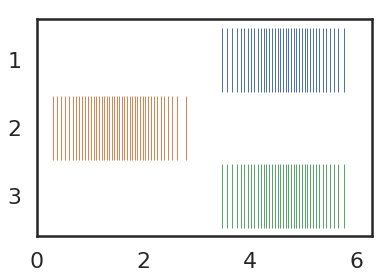

In [6]:
with nengo.Network() as model:
    node = nengo.Node(lambda t: np.sin(t))
    ens = nengo.Ensemble(3, 1, neuron_type=DurstewitzNeuron(), max_rates=Uniform(20, 40), seed=2)
    conn = nengo.Connection(node, ens, synapse=None, solver=NoSolver(np.zeros((3, 1))), label='conn')
    p = nengo.Probe(ens.neurons, 'spikes', synapse=None)
with nengo.Simulator(model) as sim:
    sim.run(2*np.pi)
    reset_neuron(sim)
fig, ax = plt.subplots()
rasterplot(sim.trange(), sim.data[p], ax=ax)
plt.show()

# Simulations

## Default Nengo Oscillator Example

In [84]:
def go_default(n_neurons=300, t=8, freq=1, tau=0.1, dt=1e-3, neuron_type=nengo.LIF(),
        distribute_lif=False, max_rates=Default, intercepts=Default, reg=1e-1):
    
    w = 2*np.pi*freq
    A = [[0, -w], [w, 0]]
    A_ens = [[1, 0], [0, 1]] + tau*np.array(A)
    
    with nengo.Network(seed=0) as model:
        stim = nengo.Node(nengo.processes.Piecewise({0: [1, 0], 0.1: [0, 0]}))
        neuron_type = neuron_type
        lif = nengo.Ensemble(n_neurons, 2, neuron_type=neuron_type,
            max_rates=max_rates, intercepts=intercepts, radius=2)
        nengo.Connection(stim, lif, synapse=None)
        nengo.Connection(lif, lif, synapse=tau, solver=LstsqL2(reg=reg), transform=A_ens)
        p_lif = nengo.Probe(lif, synapse=tau)
        
    with nengo.Simulator(model, seed=0, dt=dt) as sim:
        if distribute_lif:
#             init_lif(sim, lif, x0=[0, 0])
            sim.signals[sim.model.sig[lif.neurons]['voltage']] = (
                np.random.RandomState(seed=0).rand(n_neurons))
        sim.run(t)
        
    fig, ax = plt.subplots(figsize=((12, 8)))
    ax.plot(sim.trange(), sim.data[p_lif][:,0], label='$\hat{x}_0$')
    ax.plot(sim.trange(), sim.data[p_lif][:,1], label='$\hat{x}_1$')
    plt.legend()
    plt.show()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

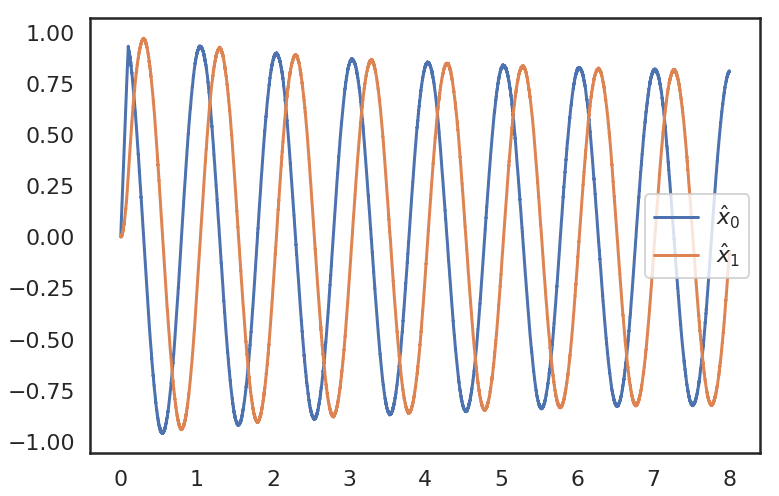

In [77]:
go_default(max_rates=Uniform(200, 400))

### low rates, LIF

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

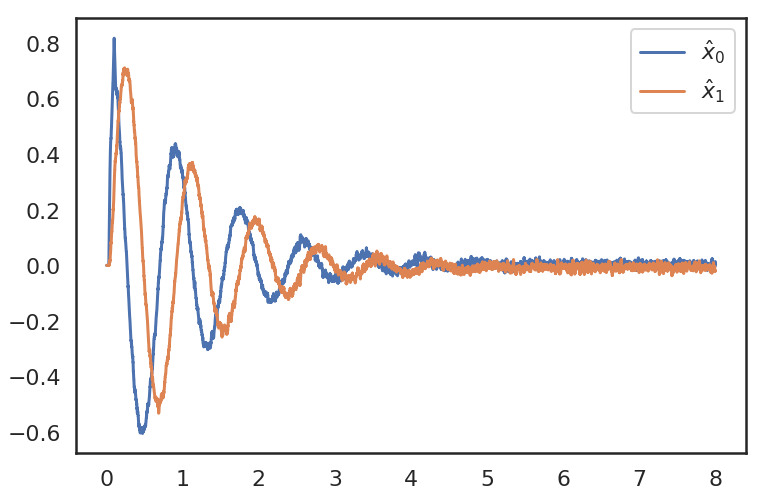

In [155]:
go_default(n_neurons=3000, max_rates=Uniform(20, 40))

fewer neurons actually does better...

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

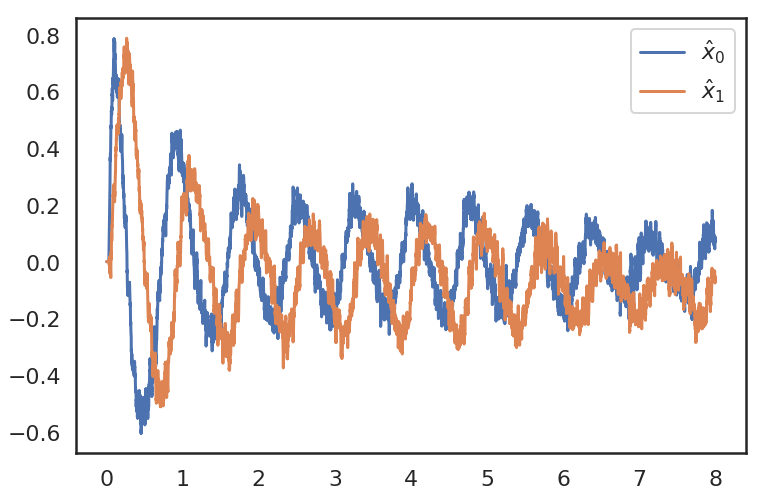

In [79]:
go_default(n_neurons=200, max_rates=Uniform(20, 40))

### low rates, spiking ReLu

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

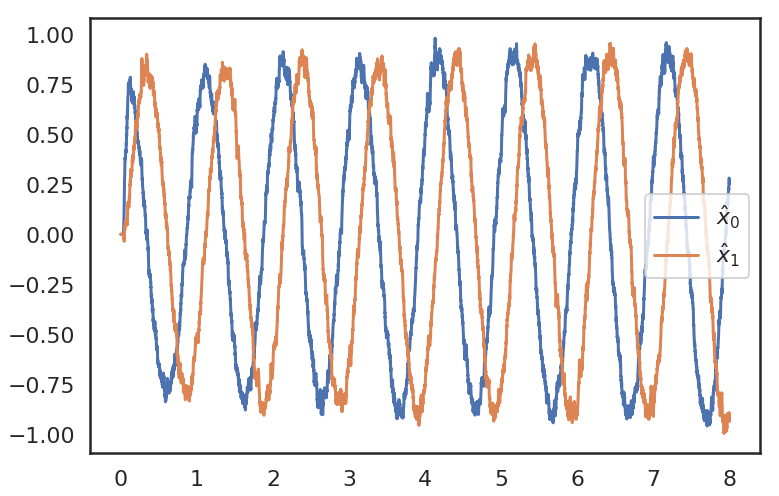

In [80]:
go_default(max_rates=Uniform(20, 40), neuron_type=nengo.SpikingRectifiedLinear())

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

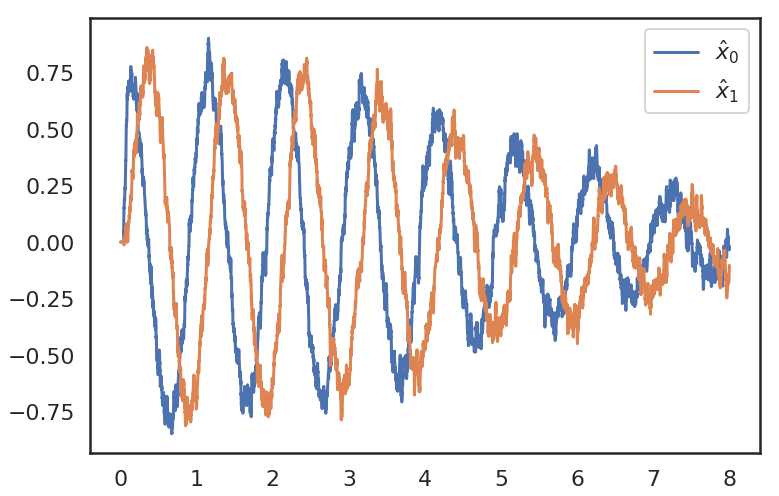

In [81]:
go_default(n_neurons=200, max_rates=Uniform(20, 40), neuron_type=nengo.SpikingRectifiedLinear())

### Distributing initial voltages doesn't immediately solve the problem

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

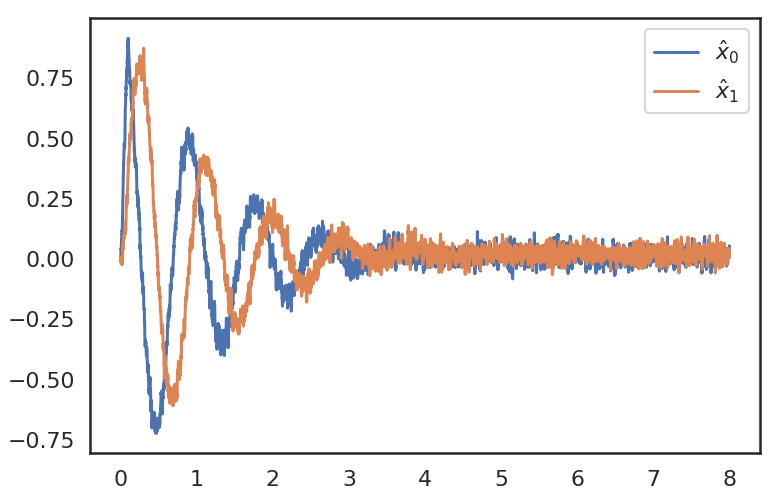

In [128]:
go_default(max_rates=Uniform(20, 40), distribute_lif=True)

### Collapse intercepts around zero

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

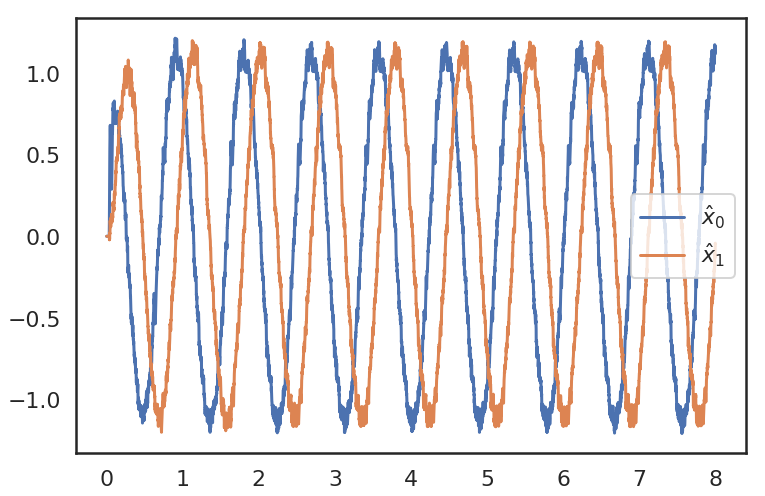

In [133]:
go_default(max_rates=Uniform(20, 40), intercepts=Uniform(0, 0))

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

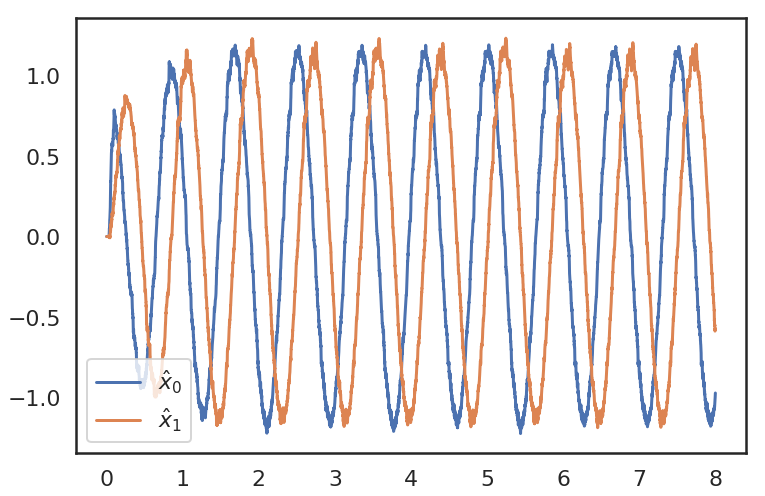

In [135]:
go_default(max_rates=Uniform(20, 40), intercepts=Uniform(-0.4, 0.4))

## Oscillator with target values computed in math

In [130]:
def go_oscillator(n_neurons=300, t=8, freq=1, tau=0.1, dt=1e-3, k_kick=-1, t_kick=0.5, max_rates=Default):
    
    w = 2*np.pi*freq
    A = [[0, -w], [w, 0]]
    B = [[1], [0]]
    C = [[1, 0]]
    D = [[0]]
    A_ens = [[1, 0], [0, 1]] + tau*np.array(A)
    
    sys = LinearSystem((A, B, C, D))
    msys = ss2sim(sys, synapse=~s, dt=dt)
    
    def kick_gate(x):
        return x[:2] * (x[2] != k_kick)
    
    with nengo.Network(seed=0) as model:
        # nodes
        kick_ens = nengo.Node(lambda t: k_kick if t<=t_kick else 0)
        kick_tar = nengo.Node(lambda t: 1/dt if t<=dt else 0)
        fb_gate_lif = nengo.Ensemble(1, 3, neuron_type=nengo.Direct())
        # ensembles
        lif = nengo.Ensemble(n_neurons, 2, neuron_type=nengo.LIF(), max_rates=max_rates, radius=np.sqrt(2))
        tar = nengo.Ensemble(1, 2, neuron_type=Direct())
        # kick connections
        nengo.Connection(kick_ens, lif, synapse=None, transform=msys.B)
        nengo.Connection(kick_tar, tar, synapse=~s, transform=msys.B)
        nengo.Connection(kick_ens, fb_gate_lif[2], synapse=None)
        # feedback connections
        nengo.Connection(lif, fb_gate_lif[:2], synapse=tau, transform=A_ens)
        nengo.Connection(fb_gate_lif, lif, synapse=None, function=kick_gate)
#         nengo.Connection(lif, lif, synapse=tau, transform=A_ens)
        nengo.Connection(tar, tar, synapse=~s, transform=msys.A)
        p_lif = nengo.Probe(lif, synapse=tau)
        p_tar = nengo.Probe(tar, synapse=None)
        
    with nengo.Simulator(model, seed=0, dt=dt) as sim:
        sim.run(t)
        
    fig, ax = plt.subplots(figsize=((12, 8)))
    ax.plot(sim.trange(), sim.data[p_lif][:,0], label='$\hat{x}_0$')
    ax.plot(sim.trange(), sim.data[p_lif][:,1], label='$\hat{x}_1$')
    ax.plot(sim.trange(), sim.data[p_tar][:,0], label='$x_0$')
    ax.plot(sim.trange(), sim.data[p_tar][:,1], label='$x_1$')
    plt.legend()
    plt.show()

### confirm estimates align with targets (i.e. make sure kick and nodes are working as intended)

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:198: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

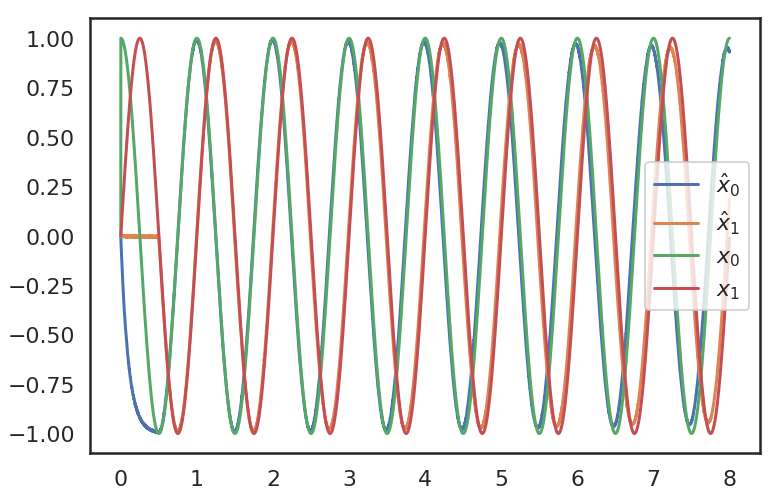

In [133]:
go_oscillator()

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:198: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

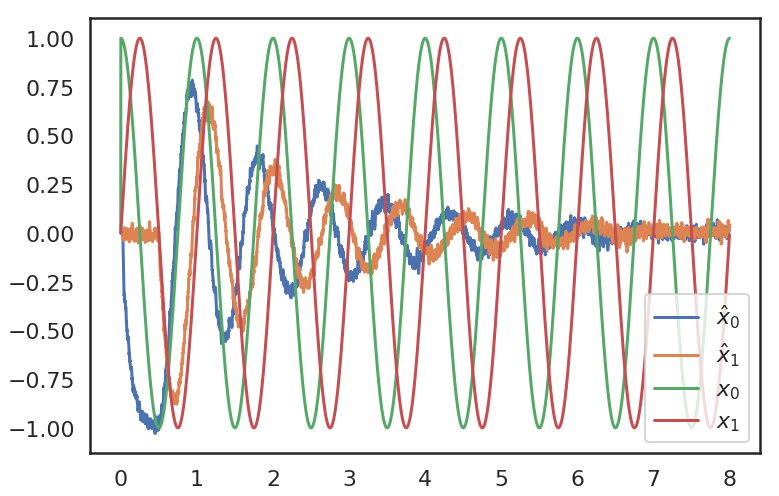

In [121]:
go_oscillator(max_rates=Uniform(20, 40))

## Oscillator with decoders and filters optimized to match target

In [7]:
def go_oracle(d, h, n_neurons=300, t=8, t_supv=8, t_trans=0,
        neuron_type=nengo.LIF(), neuron_type_supv=nengo.SpikingRectifiedLinear(),
        max_rates=Default, intercepts=Default, supv=1, order=1, pf=True, maxiter=5, opt=False,
        reg=0.1, freq=1, tau=0.1, dt=1e-3):
    
    assert t_supv <= t, 'supervision time must be <= total time'
    w = 2*np.pi*freq
    A = [[0, -w], [w, 0]]
    B = [[1], [0]]
    C = [[1, 0]]
    D = [[0]]
    
    sys = LinearSystem((A, B, C, D))
    msys = ss2sim(sys, synapse=~s, dt=dt)

    # gates
    def supv_gate_func(t, x):
        if t <= t_supv:
            return x
        elif t_supv < t <= t_supv + t_trans:
            return ((t_supv-t+t_trans)/t_trans) * x
        else:
            return 0*x
    def ens_gate_func(t, x):
        if t <= t_supv:
            return 0*x
        elif t_supv < t <= t_supv + t_trans:
            return ((t-t_supv)/t_trans) * x
        else:
            return x
        
    with nengo.Network(seed=0) as model:
  
        # nodes
        kick = nengo.Node(lambda t: 1/dt if t<=dt else 0)
        tar = nengo.Ensemble(1, 2, neuron_type=Direct())
        supv_gate = nengo.Node(size_in=2, size_out=2, output=supv_gate_func)
        ens_gate = nengo.Node(size_in=2, size_out=2, output=ens_gate_func)
        # ensembles
        supv = nengo.Ensemble(n_neurons, 2, neuron_type=neuron_type_supv,
            max_rates=max_rates, intercepts=intercepts, radius=2)
        ens = nengo.Ensemble(n_neurons, 2, neuron_type=neuron_type,
            max_rates=max_rates, intercepts=intercepts, radius=2)
        # target connections
        nengo.Connection(kick, tar, synapse=~s, transform=msys.B)
        nengo.Connection(tar, tar, synapse=~s, transform=msys.A)
        # supervisor connections
        nengo.Connection(tar, supv, synapse=None)
        nengo.Connection(supv, supv_gate, synapse=tau)
        nengo.Connection(supv_gate, ens, synapse=None)
        # ensemble connections
        nengo.Connection(ens, ens_gate, synapse=h, solver=NoSolver(d))
        fb = nengo.Connection(ens_gate, ens, synapse=None)
        if opt:
            gbtrain = nengo.Connection(ens, ens, synapse=h,
                solver=NoSolver(np.zeros_like(d)), label='gbtrain')
        # probes
        p_supv_gate = nengo.Probe(supv_gate, synapse=None)
        p_ens_gate = nengo.Probe(ens_gate, synapse=None)
        p_spk = nengo.Probe(ens.neurons, synapse=None)
        p_tar = nengo.Probe(tar, synapse=None)

#     if opt:
#         gain_bias_dict = conn_opt([gbtrain], maxiter=maxiter, stim_func=lambda t: [np.sin(t), np.cos(t)],
#             pt=True, neurons_per_plot=n_neurons)
#     with warnings.catch_warnings():
#         warnings.simplefilter("ignore")
#         fb.gain = gain_bias_dict['gbtrain']['gain']
#         fb.bias = gain_bias_dict['gbtrain']['bias']

    with nengo.Simulator(model, seed=0, dt=dt) as sim:
        sim.run(t)

    # train filters and decoders on spikes from ens under supervision
    if supv:
        d, h = update_h_hyperopt(
            Lowpass(tau).filt(sim.data[p_tar][:int(t_supv/dt)], dt=dt),
            sim.data[p_spk][:int(t_supv/dt)],
            order=order, dt=dt)
#         d = LstsqL2(reg=reg)(
#             Lowpass(tau).filt(sim.data[p_spk][:int(t_supv/dt)], dt=dt),
#             Lowpass(tau).filt(sim.data[p_tar][:int(t_supv/dt)], dt=dt))[0]
    if pf:
        times = np.arange(0, 1, 0.0001)
        y_tar = Lowpass(0.1).impulse(len(times), dt=0.0001)
        y = h.impulse(len(times), dt=0.0001)
        fig, ax = plt.subplots(figsize=((12, 8)))
        ax.plot(times, y_tar, label="h_tar")
        ax.plot(times, y, label="h")
        ax.set(xlabel='time (seconds)', ylabel='impulse response', ylim=((0, 10)))
        ax.legend(loc='upper right')
        plt.tight_layout()
        plt.show()
        
    a_ens = h.filt(sim.data[p_spk], dt=dt)
    tar = Lowpass(tau).filt(sim.data[p_tar], dt=dt)
    supv_gate = sim.data[p_supv_gate]
    ens_gate = sim.data[p_ens_gate]
    times = sim.trange(sample_every=dt)
    xhat = np.dot(a_ens, d)
    
    fig, ax = plt.subplots(figsize=((12, 8)))
    ax.plot(times, xhat[:,0], label='$\hat{x}_0$')
    ax.plot(times, xhat[:,1], label='$\hat{x}_1$')
    ax.plot(times, tar[:,0], label='$x_0$')
    ax.plot(times, tar[:,1], label='$x_1$')
#     ax.plot(times, supv_gate[:,0], label='$x_0$ (supv_gate)')
#     ax.plot(times, supv_gate[:,1], label='$x_1$ (supv_gate)')
#     ax.plot(times, ens_gate[:,0], label='$x_0$ (ens_gate)')
#     ax.plot(times, ens_gate[:,1], label='$x_1$ (ens_gate)')
    ax.set(title='supervised = %s'%(supv==1))
    plt.axvline(x=t_supv, color='b', lw=4)
    plt.axvline(x=t_supv+t_trans, color='r', lw=4)
    plt.legend(loc='lower right')
    plt.show()
    
    return d, h

### High Rates

In [143]:
d_init = np.zeros((n_neurons, 2))
h_init = Lowpass(0.1)

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:198: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

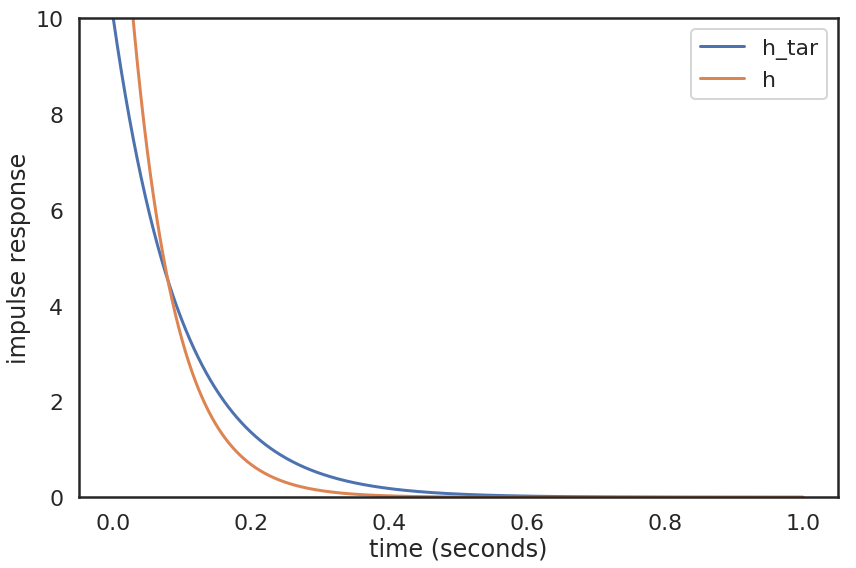

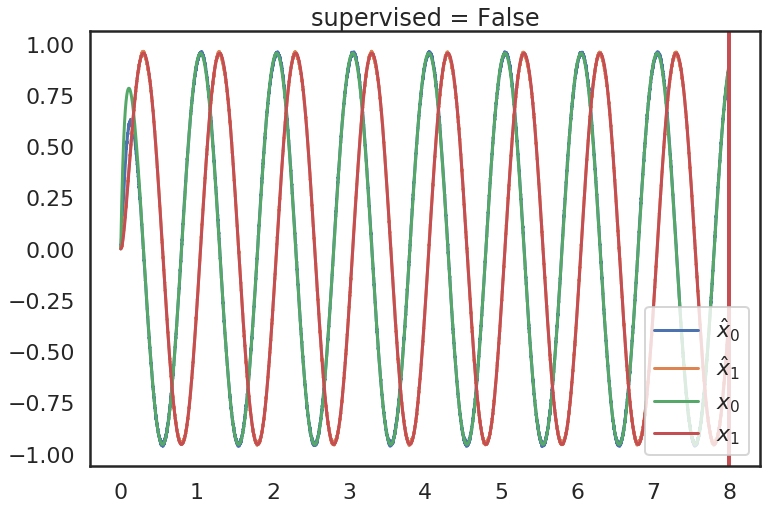

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

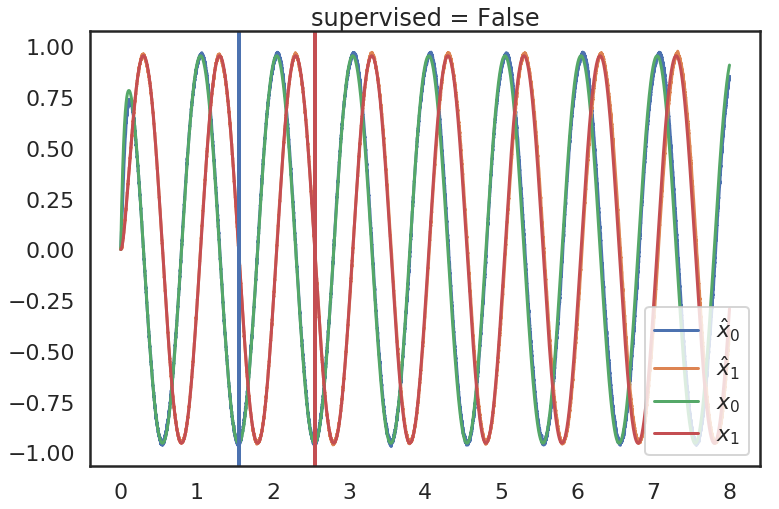

In [144]:
nt = nengo.LIF()

d, h = go_oracle(d_init, h_init, t=8, t_supv=8, t_trans=0, n_neurons=n_neurons,
    neuron_type=nt, max_rates=Uniform(200, 400), tau=0.05, supv=1, pf=True)

_, _ = go_oracle(d, h, t=8, t_supv=1.55, t_trans=1, n_neurons=n_neurons,
    neuron_type=nt, max_rates=Uniform(200, 400), tau=0.05, supv=0, pf=False)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:198: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

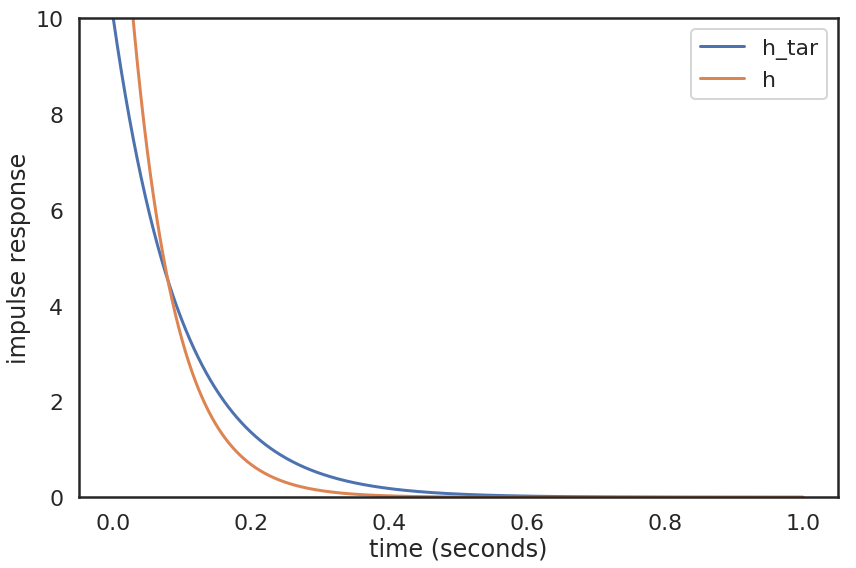

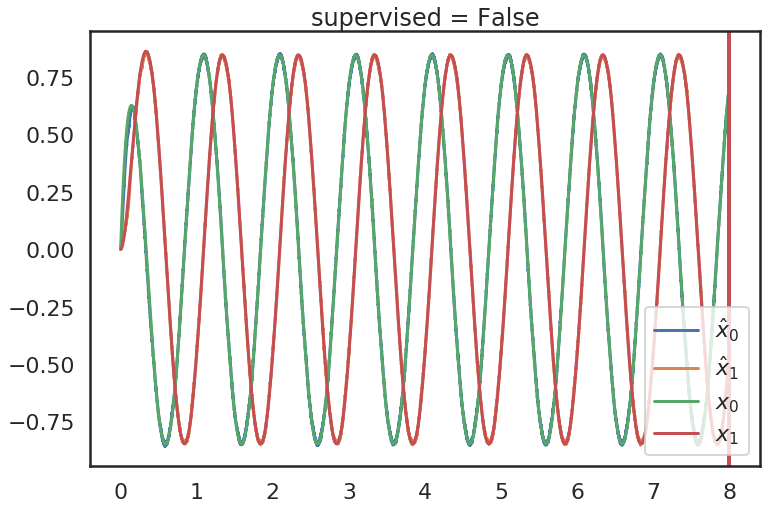

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

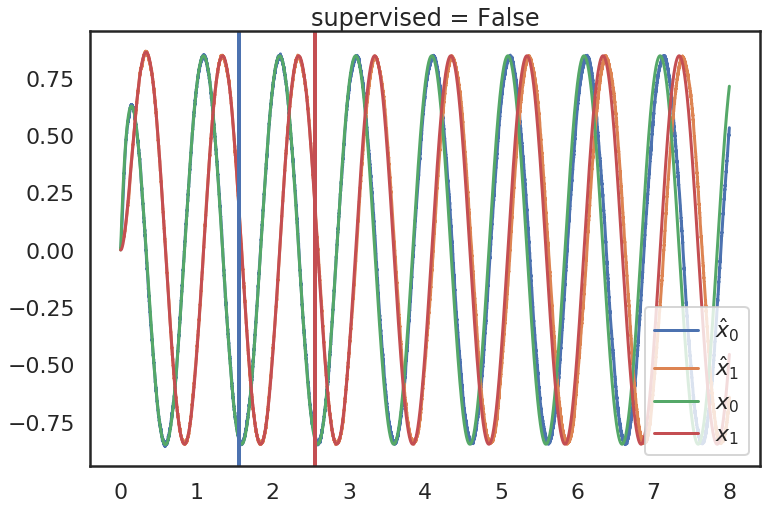

In [145]:
nt = AdaptiveLIFT(tau_adapt=0.1, inc_adapt=0.1)

d, h = go_oracle(d_init, h_init, t=8, t_supv=8, t_trans=0, n_neurons=n_neurons,
    neuron_type=nt, max_rates=Uniform(200, 400), tau=0.1, supv=1, pf=True)

_, _ = go_oracle(d, h, t=8, t_supv=1.55, t_trans=1, n_neurons=n_neurons,
    neuron_type=nt, max_rates=Uniform(200, 400), tau=0.1, supv=0, pf=False)

## Low Rates

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:198: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

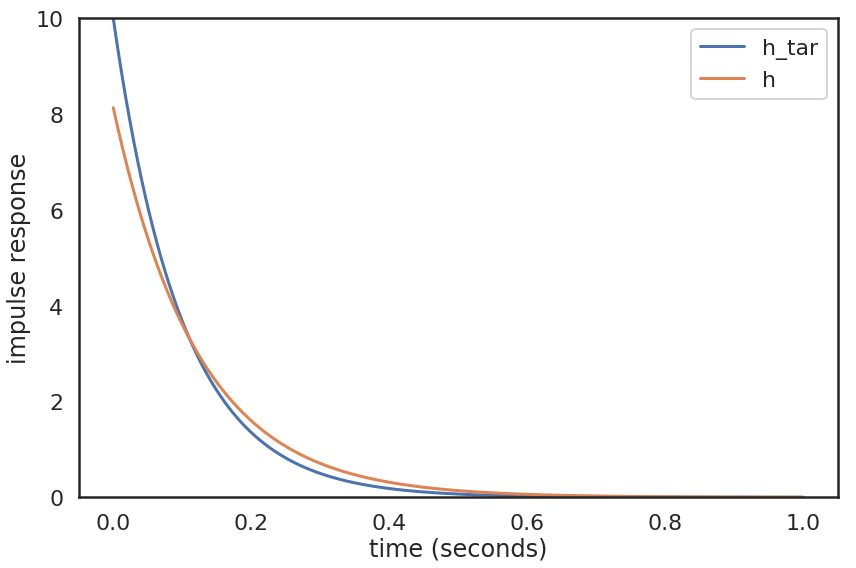

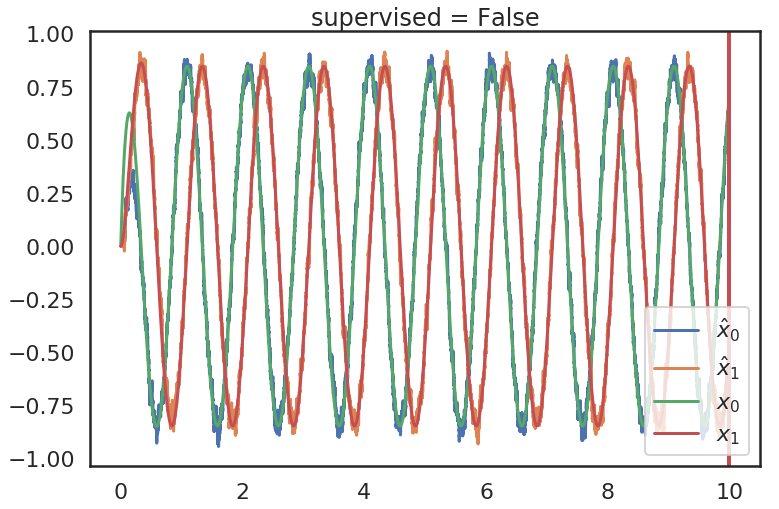

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

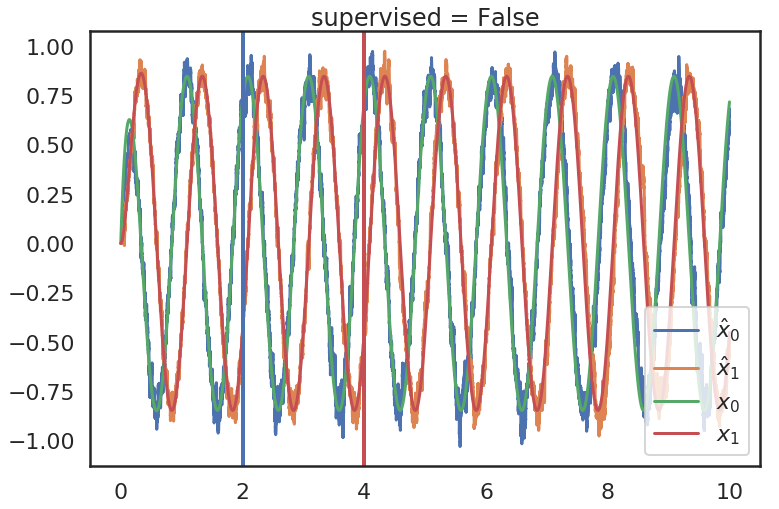

In [189]:
n_neurons = 300
d_init = np.zeros((n_neurons, 2))
h_init = Lowpass(0.1)

nt = nengo.SpikingRectifiedLinear()

d, h = go_oracle(d_init, h_init, t=10, t_supv=10, n_neurons=n_neurons, dt=0.000025,
    neuron_type=nt, max_rates=Uniform(20, 40), tau=0.1, supv=1, pf=True)

_, _ = go_oracle(d, h, t=10, t_supv=2, t_trans=2, n_neurons=n_neurons, dt=0.000025,
    neuron_type=nt, max_rates=Uniform(20, 40), tau=0.1, supv=0, pf=False)

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:198: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

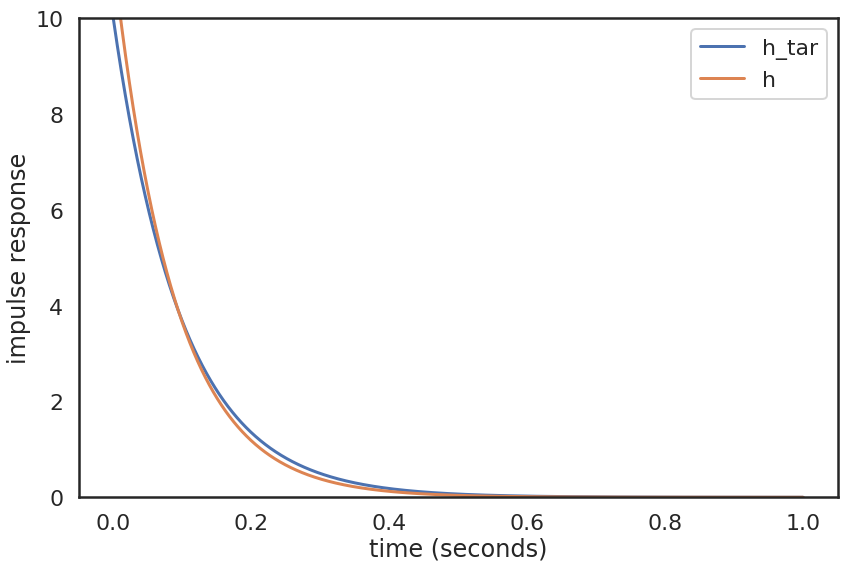

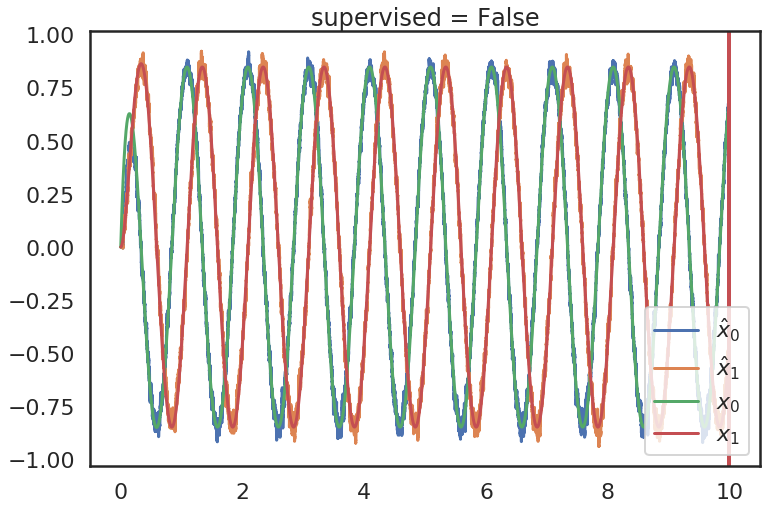

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

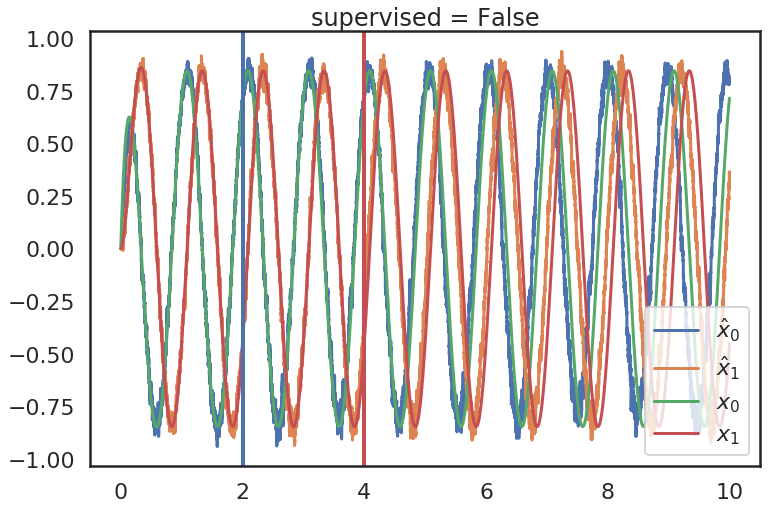

In [190]:
n_neurons = 300
d_init = np.zeros((n_neurons, 2))
h_init = Lowpass(0.1)
nt = nengo.LIF()

d, h = go_oracle(d_init, h_init, t=10, t_supv=10, n_neurons=n_neurons, dt=0.000025,
    neuron_type=nt, max_rates=Uniform(20, 40), tau=0.1, supv=1, pf=True)

_, _ = go_oracle(d, h, t=10, t_supv=2, t_trans=2, n_neurons=n_neurons, dt=0.000025,
    neuron_type=nt, max_rates=Uniform(20, 40), tau=0.1, supv=0, pf=False)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:198: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

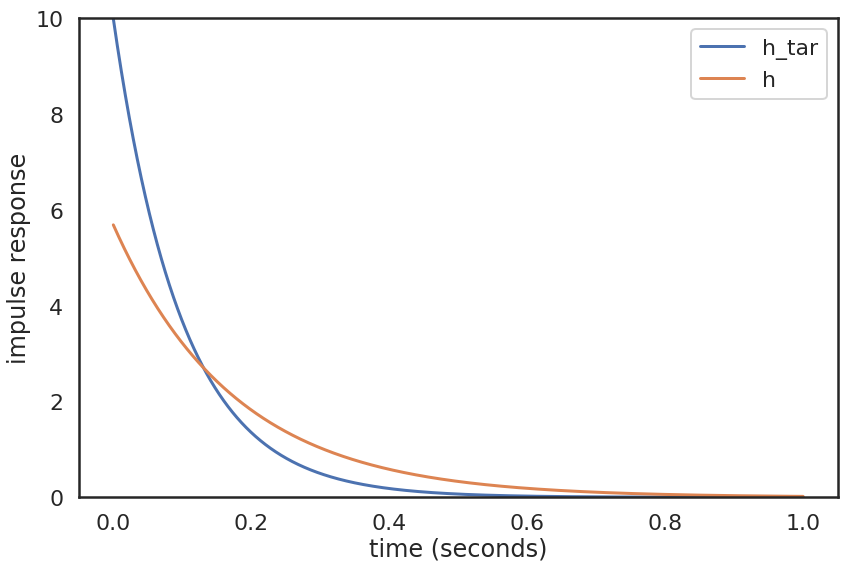

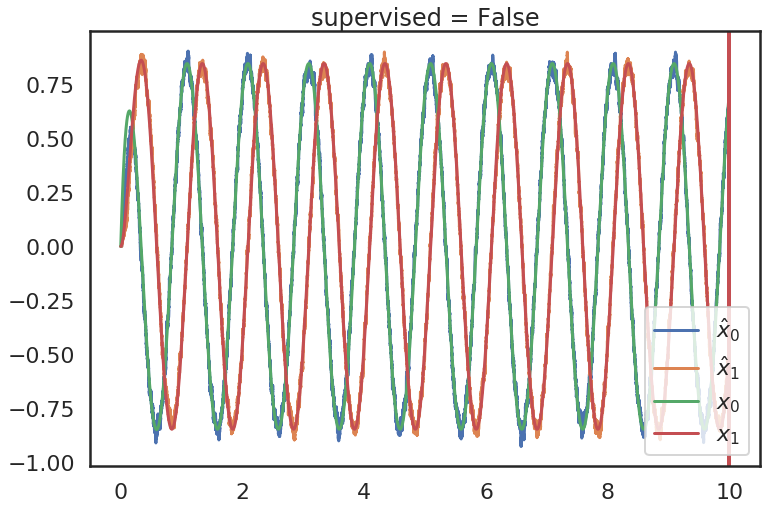

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

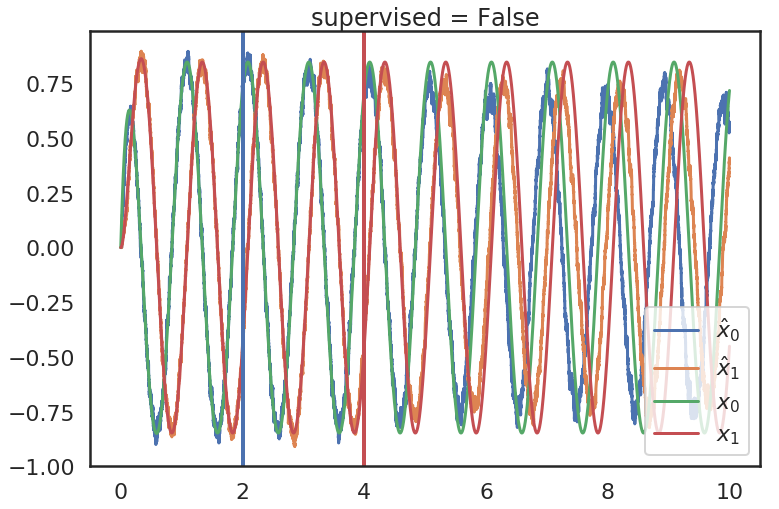

In [191]:
n_neurons = 300
d_init = np.zeros((n_neurons, 2))
h_init = Lowpass(0.1)
nt = AdaptiveLIFT(tau_adapt=0.1, inc_adapt=0.1)

d, h = go_oracle(d_init, h_init, t=10, t_supv=10, n_neurons=n_neurons, dt=0.000025,
    neuron_type=nt, max_rates=Uniform(20, 40), tau=0.1, supv=1, pf=True)

_, _ = go_oracle(d, h, t=10, t_supv=2, t_trans=2, n_neurons=n_neurons, dt=0.000025,
    neuron_type=nt, max_rates=Uniform(20, 40), tau=0.1, supv=0, pf=False)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:198: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

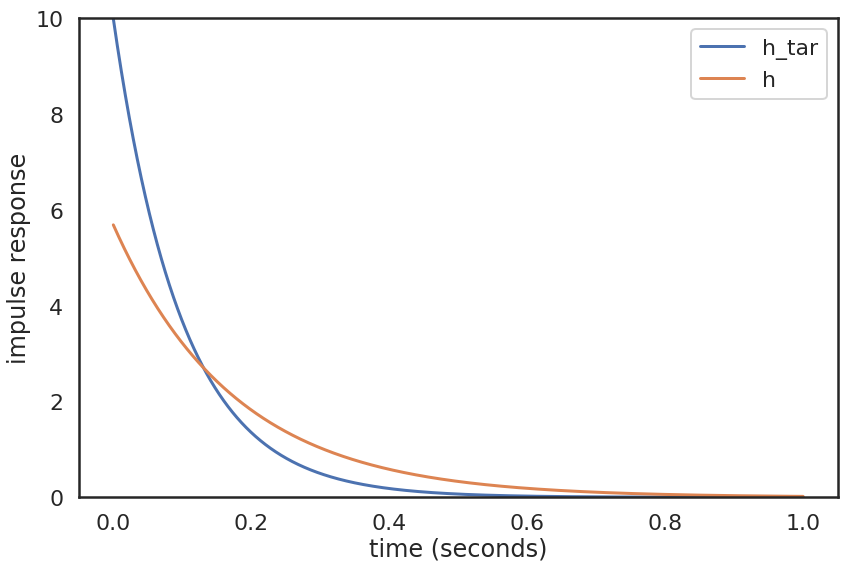

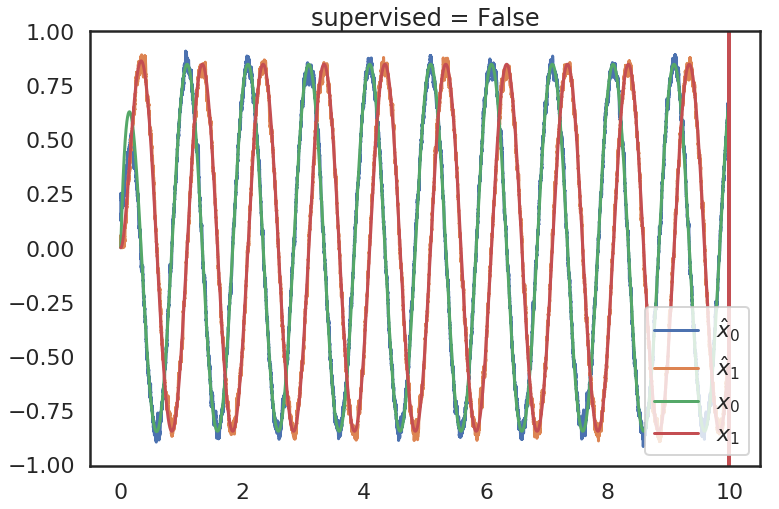

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

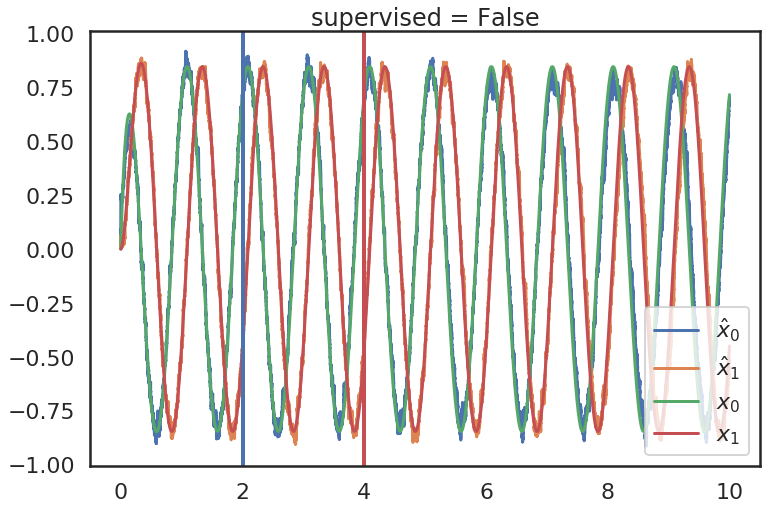

In [182]:
n_neurons = 300
d_init = np.zeros((n_neurons, 2))
h_init = Lowpass(0.1)
nt = WilsonEuler()

d, h = go_oracle(d_init, h_init, t=10, t_supv=10, n_neurons=n_neurons, dt=0.000025,
    neuron_type=nt, max_rates=Uniform(20, 40), tau=0.1, supv=1, pf=True)

_, _ = go_oracle(d, h, t=10, t_supv=2, t_trans=2, n_neurons=n_neurons, dt=0.000025,
    neuron_type=nt, max_rates=Uniform(20, 40), tau=0.1, supv=0, pf=False)

### more neurons

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:198: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

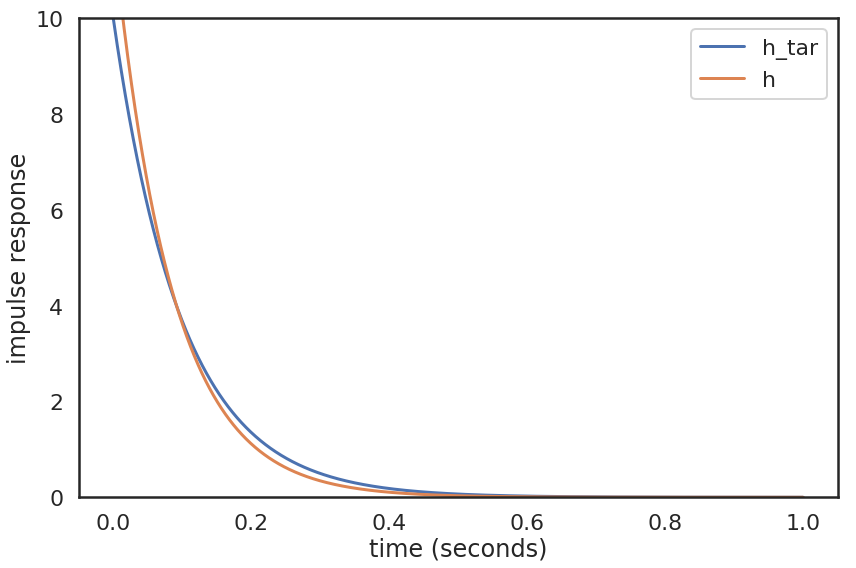

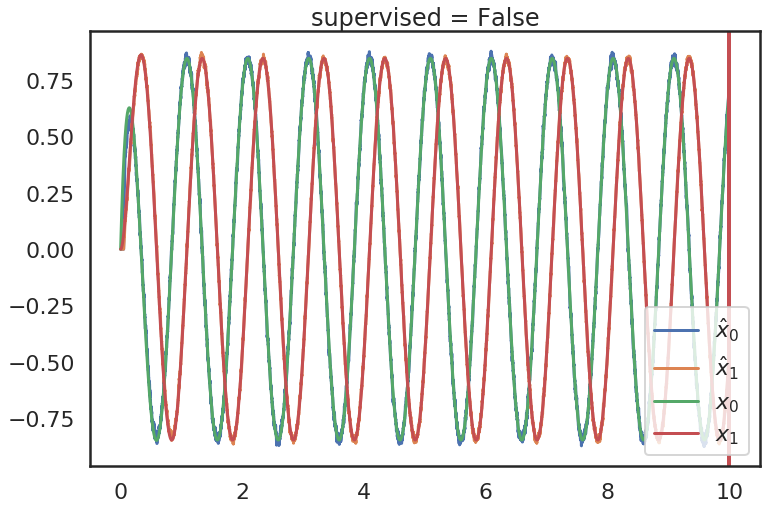

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

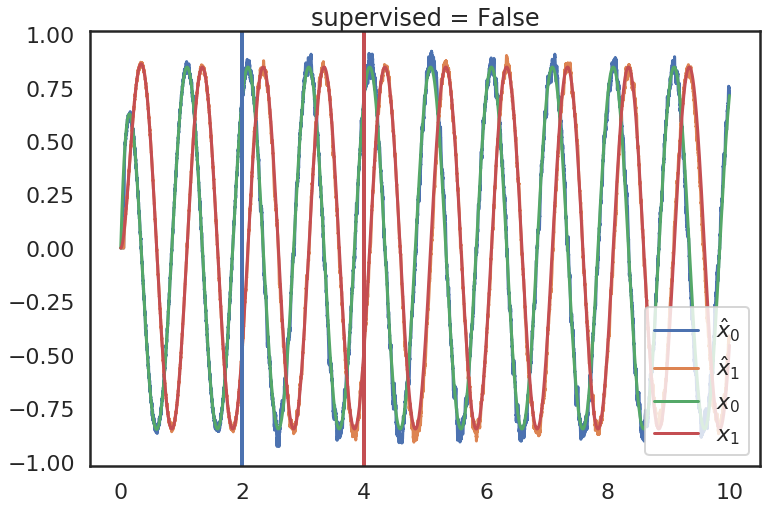

In [195]:
n_neurons = 3000
d_init = np.zeros((n_neurons, 2))
h_init = Lowpass(0.1)

nt = nengo.SpikingRectifiedLinear()

d, h = go_oracle(d_init, h_init, t=10, t_supv=10, n_neurons=n_neurons, dt=0.001,
    neuron_type=nt, max_rates=Uniform(20, 40), tau=0.1, supv=1, pf=True)

_, _ = go_oracle(d, h, t=10, t_supv=2, t_trans=2, n_neurons=n_neurons, dt=0.001,
    neuron_type=nt, max_rates=Uniform(20, 40), tau=0.1, supv=0, pf=False)

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:198: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

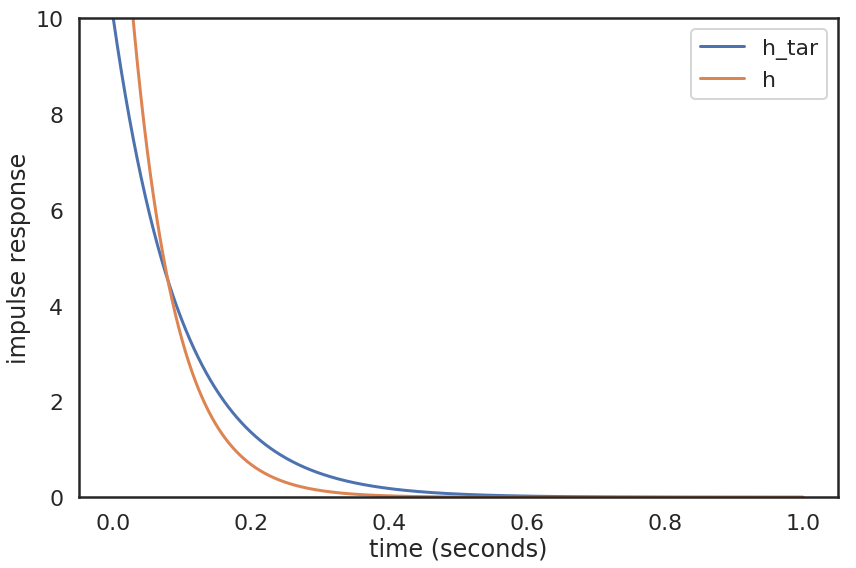

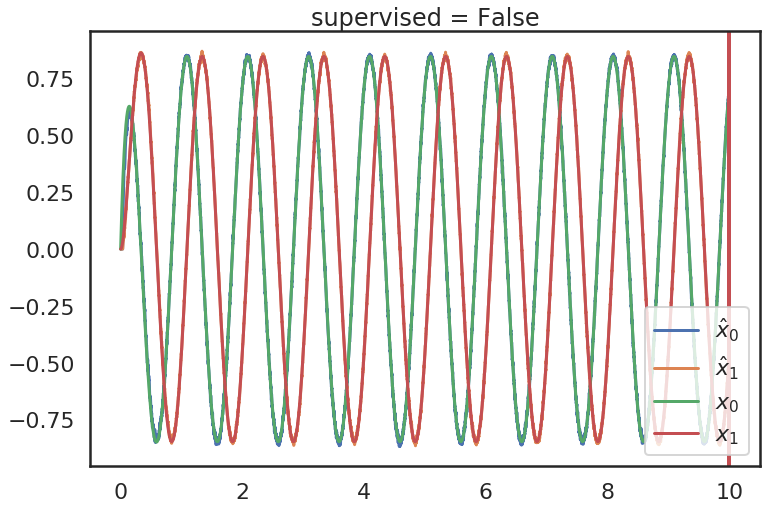

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

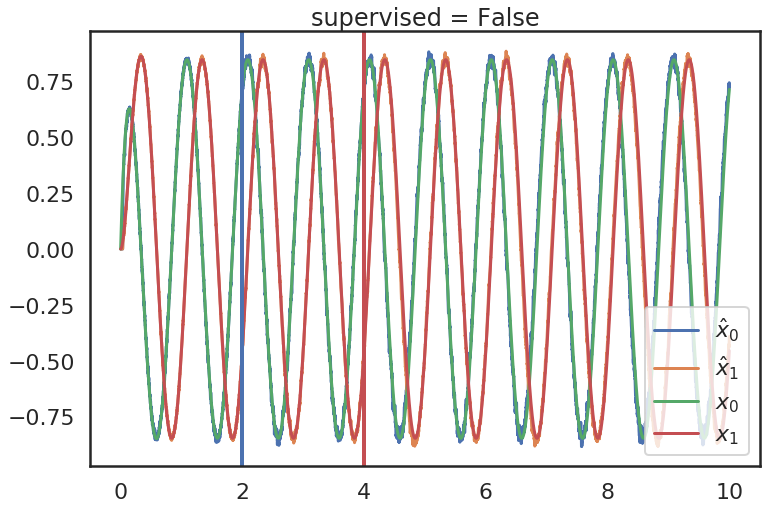

In [194]:
n_neurons = 3000
d_init = np.zeros((n_neurons, 2))
h_init = Lowpass(0.1)
nt = nengo.LIF()

d, h = go_oracle(d_init, h_init, t=10, t_supv=10, n_neurons=n_neurons, dt=0.001,
    neuron_type=nt, max_rates=Uniform(20, 40), tau=0.1, supv=1, pf=True)

_, _ = go_oracle(d, h, t=10, t_supv=2, t_trans=2, n_neurons=n_neurons, dt=0.001,
    neuron_type=nt, max_rates=Uniform(20, 40), tau=0.1, supv=0, pf=False)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:198: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

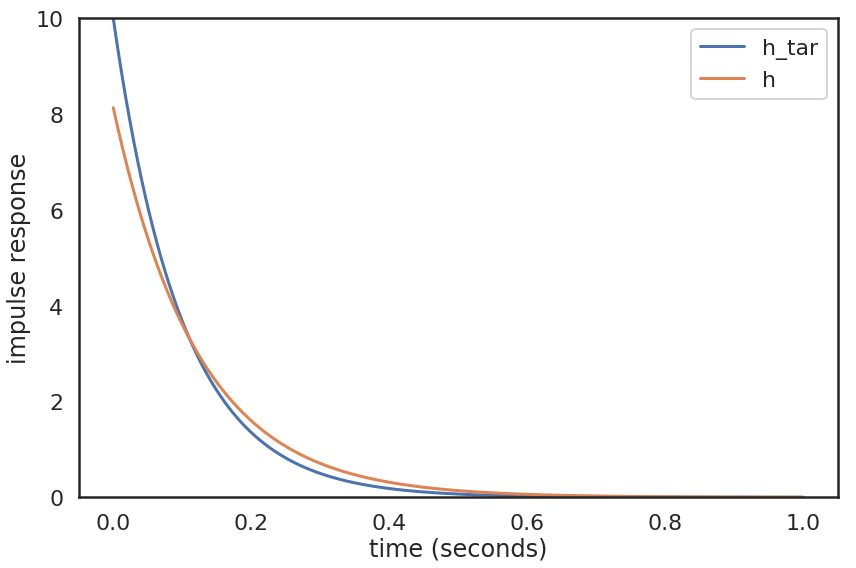

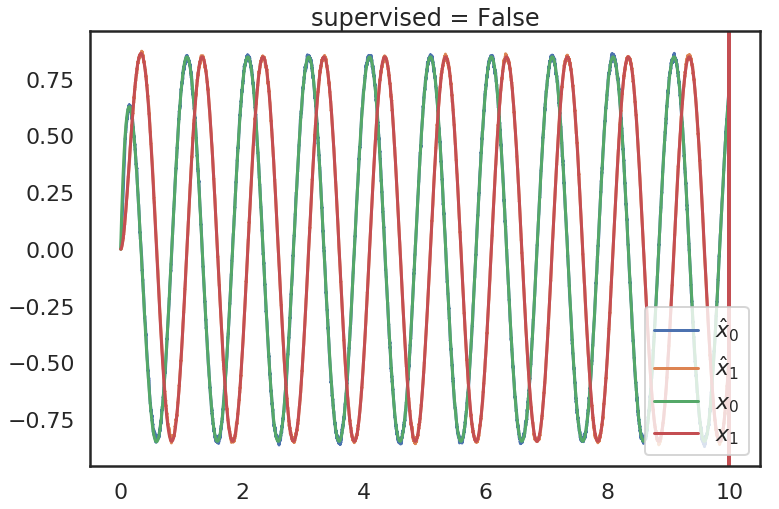

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

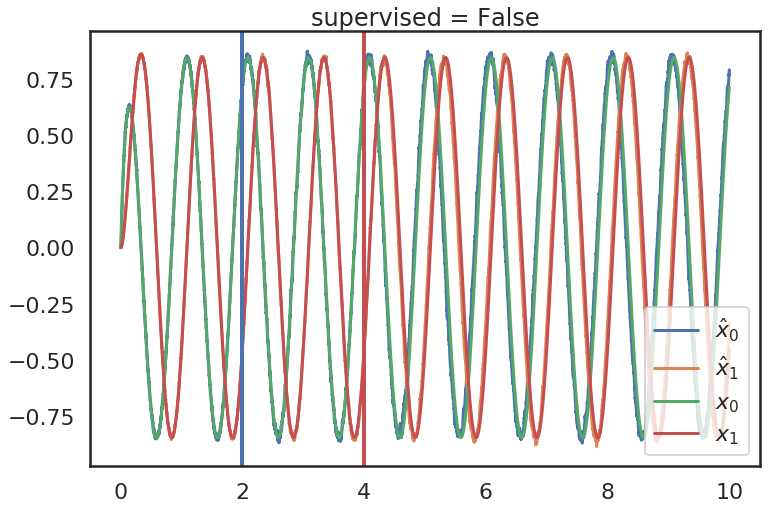

In [196]:
n_neurons = 3000
d_init = np.zeros((n_neurons, 2))
h_init = Lowpass(0.1)
nt = AdaptiveLIFT(tau_adapt=0.1, inc_adapt=0.1)

d, h = go_oracle(d_init, h_init, t=10, t_supv=10, n_neurons=n_neurons, dt=0.001,
    neuron_type=nt, max_rates=Uniform(20, 40), tau=0.1, supv=1, pf=True)

_, _ = go_oracle(d, h, t=10, t_supv=2, t_trans=2, n_neurons=n_neurons, dt=0.001,
    neuron_type=nt, max_rates=Uniform(20, 40), tau=0.1, supv=0, pf=False)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:198: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

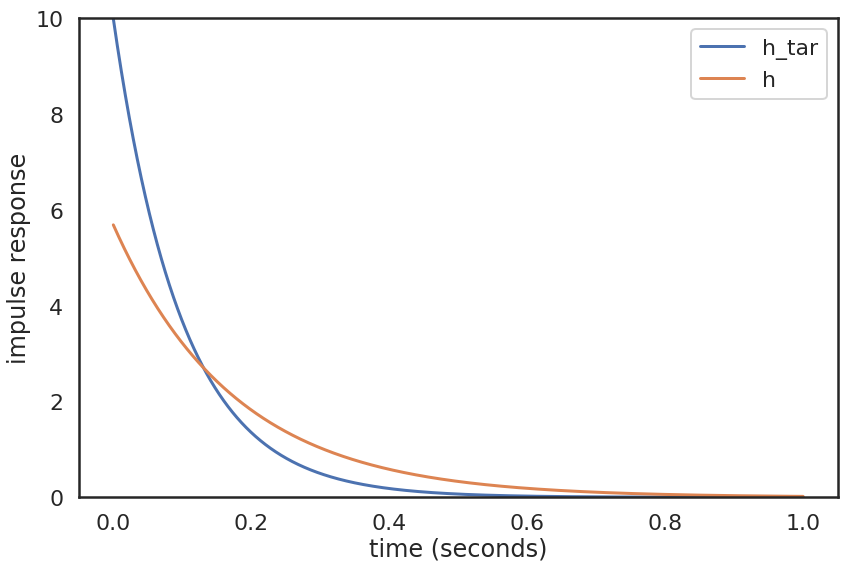

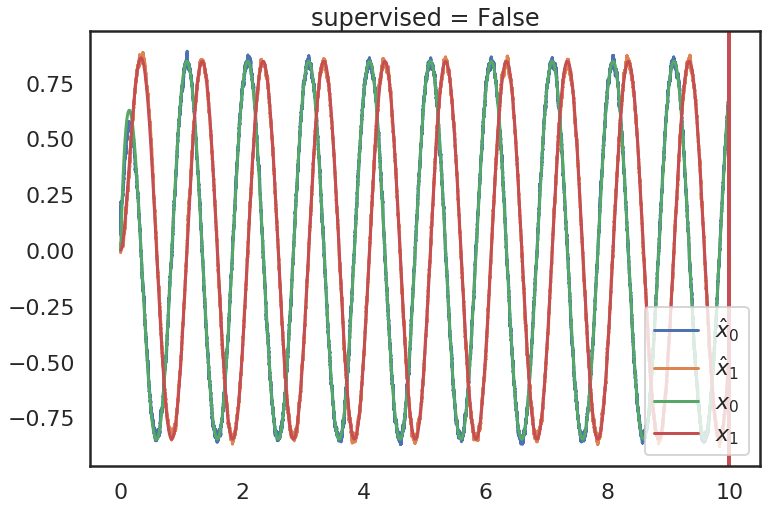

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

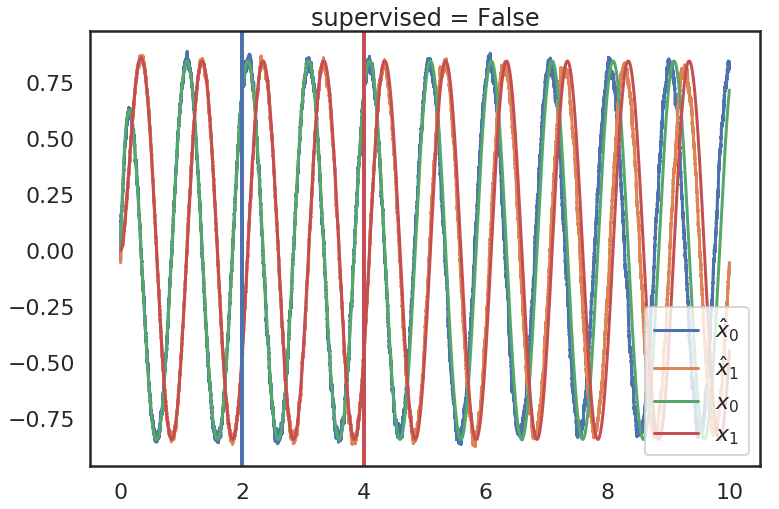

In [202]:
n_neurons = 1000
d_init = np.zeros((n_neurons, 2))
h_init = Lowpass(0.1)

nt = WilsonEuler()

d, h = go_oracle(d_init, h_init, t=10, t_supv=10, n_neurons=n_neurons, dt=0.000025,
    neuron_type=nt, max_rates=Uniform(20, 40), tau=0.1, supv=1, pf=True)

_, _ = go_oracle(d, h, t=10, t_supv=2, t_trans=2, n_neurons=n_neurons, dt=0.000025,
    neuron_type=nt, max_rates=Uniform(20, 40), tau=0.1, supv=0, pf=False)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:198: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

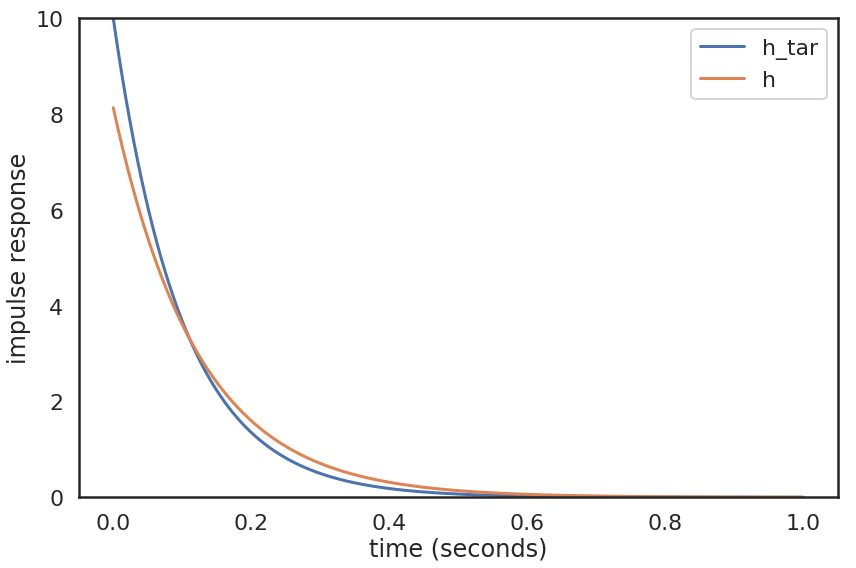

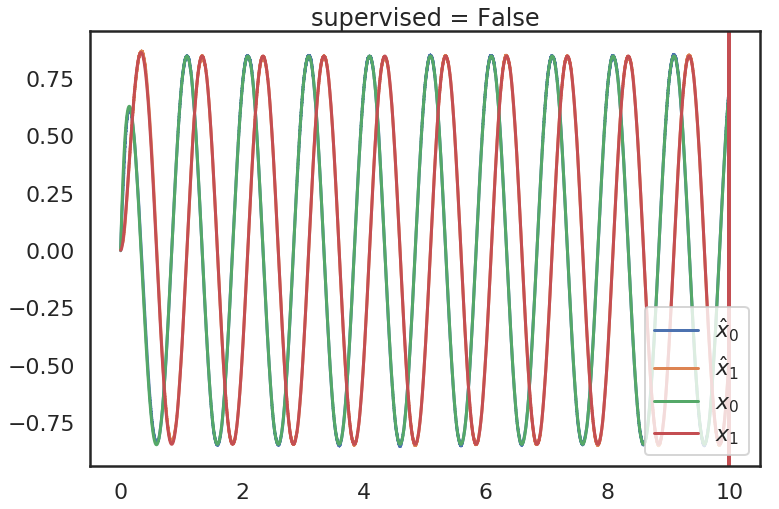

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

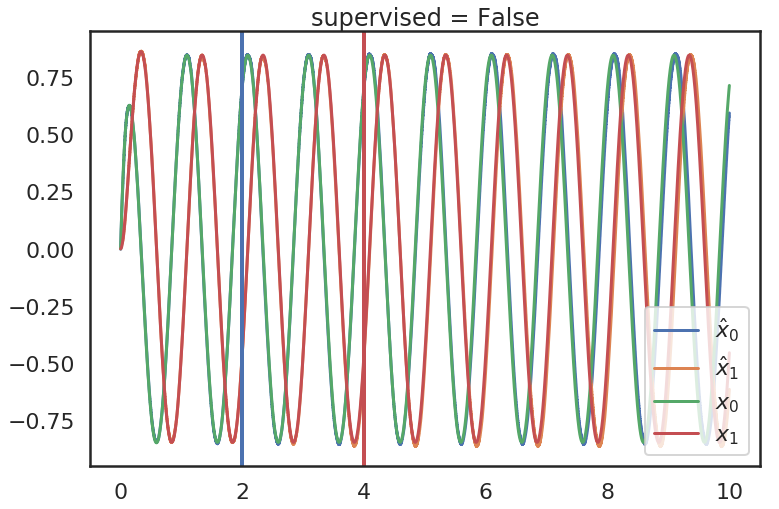

In [203]:
n_neurons = 3000
d_init = np.zeros((n_neurons, 2))
h_init = Lowpass(0.1)

nt = WilsonEuler()

d, h = go_oracle(d_init, h_init, t=10, t_supv=10, n_neurons=n_neurons, dt=0.001,
    neuron_type=nt, max_rates=Uniform(20, 40), tau=0.1, supv=1, pf=True)

_, _ = go_oracle(d, h, t=10, t_supv=2, t_trans=2, n_neurons=n_neurons, dt=0.001,
    neuron_type=nt, max_rates=Uniform(20, 40), tau=0.1, supv=0, pf=False)

## double exponential

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:198: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

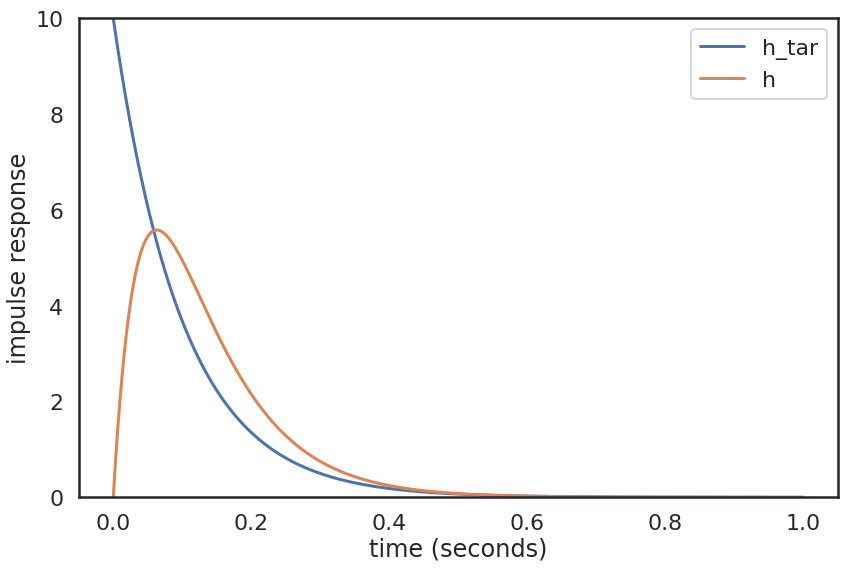

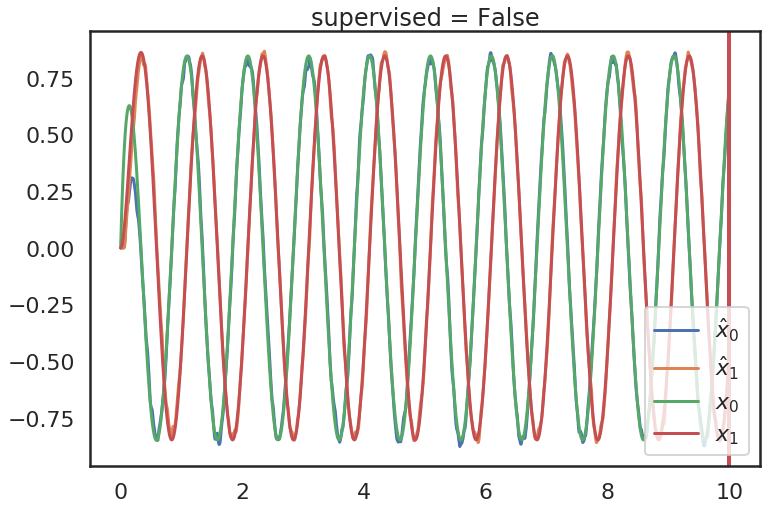

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

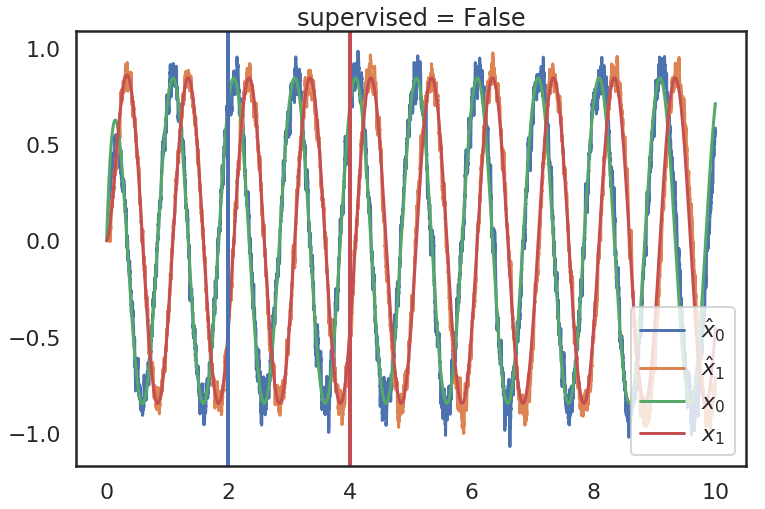

In [197]:
n_neurons = 300
d_init = np.zeros((n_neurons, 2))
h_init = Lowpass(0.1)

nt = nengo.SpikingRectifiedLinear()

d, h = go_oracle(d_init, h_init, t=10, t_supv=10, n_neurons=n_neurons, dt=0.001,
    neuron_type=nt, max_rates=Uniform(20, 40), tau=0.1, supv=1, order=2, pf=True)

_, _ = go_oracle(d, h, t=10, t_supv=2, t_trans=2, n_neurons=n_neurons, dt=0.001,
    neuron_type=nt, max_rates=Uniform(20, 40), tau=0.1, supv=0, pf=False)

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:198: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

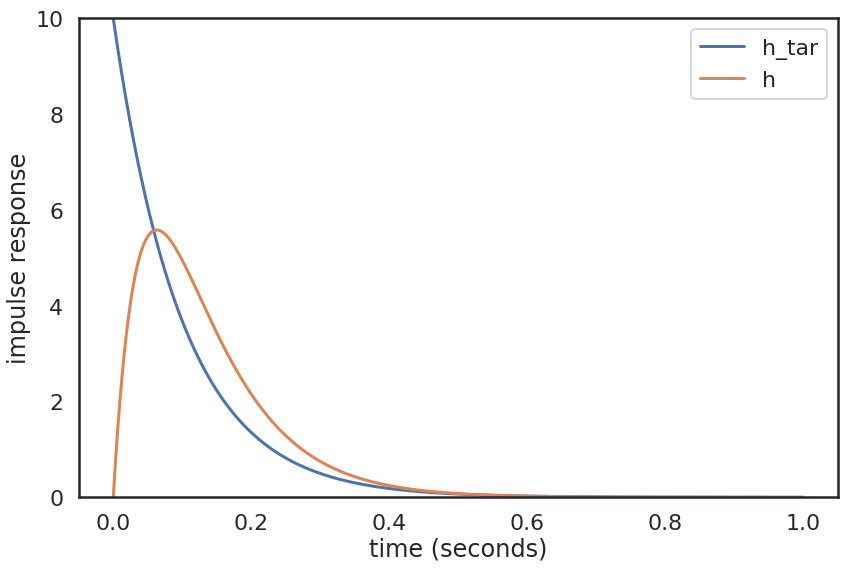

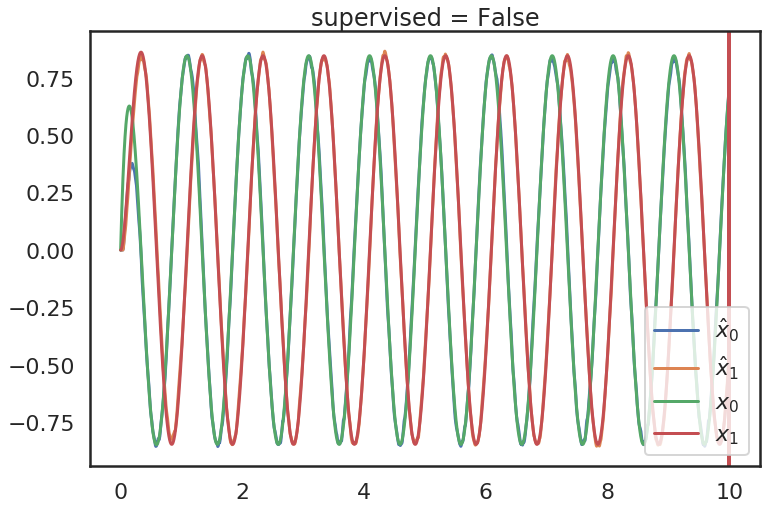

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

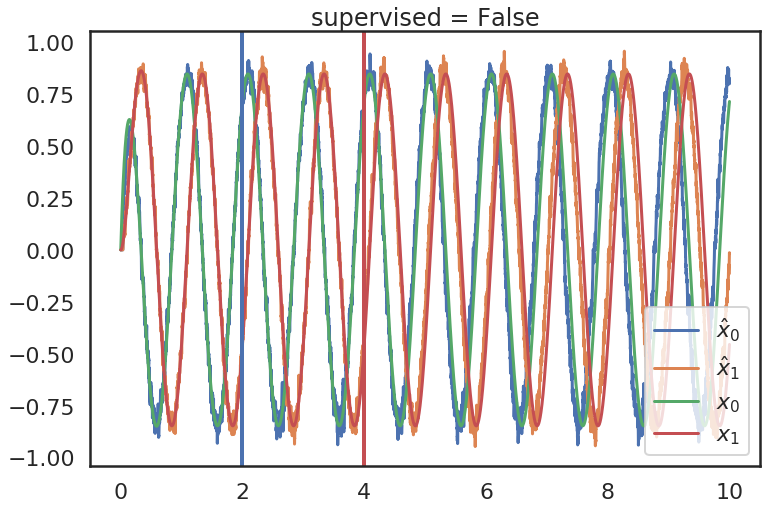

In [198]:
n_neurons = 300
d_init = np.zeros((n_neurons, 2))
h_init = Lowpass(0.1)

nt = nengo.LIF()

d, h = go_oracle(d_init, h_init, t=10, t_supv=10, n_neurons=n_neurons, dt=0.001,
    neuron_type=nt, max_rates=Uniform(20, 40), tau=0.1, supv=1, order=2, pf=True)

_, _ = go_oracle(d, h, t=10, t_supv=2, t_trans=2, n_neurons=n_neurons, dt=0.001,
    neuron_type=nt, max_rates=Uniform(20, 40), tau=0.1, supv=0, pf=False)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:198: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

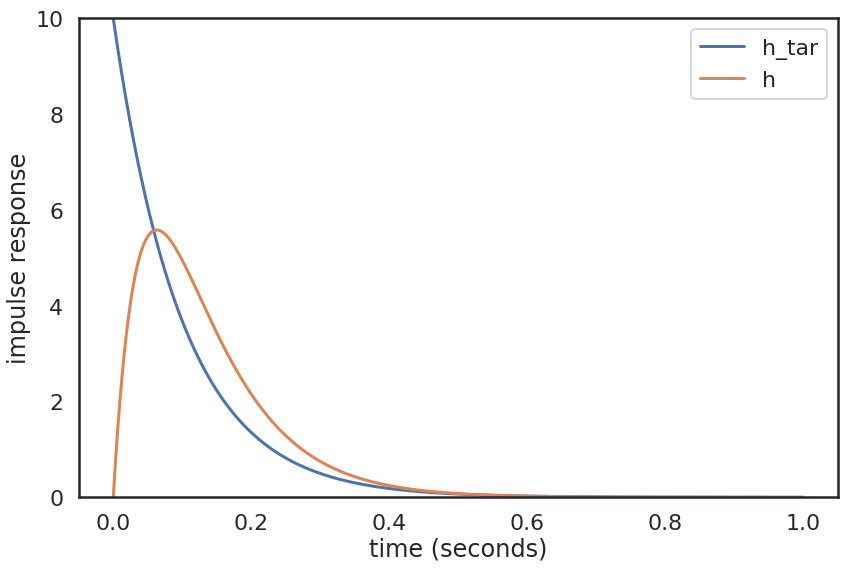

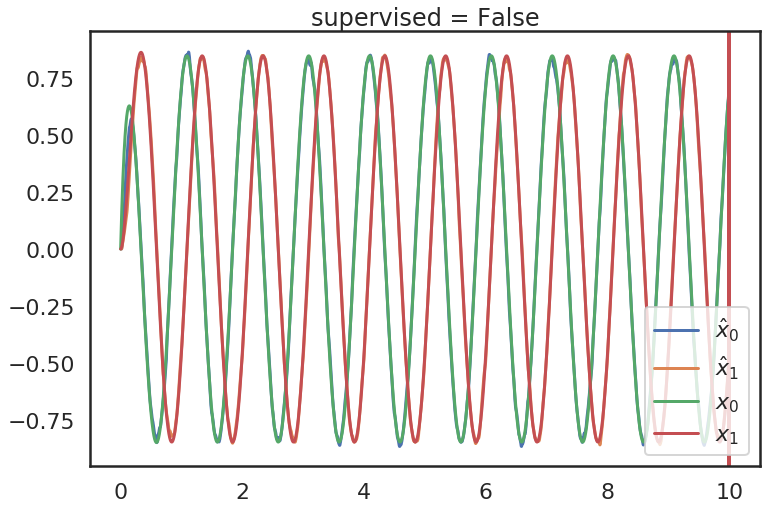

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

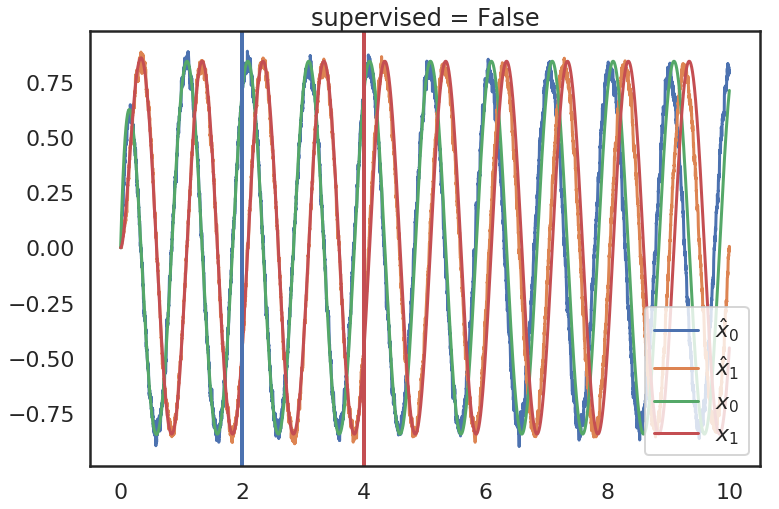

In [199]:
n_neurons = 300
d_init = np.zeros((n_neurons, 2))
h_init = Lowpass(0.1)

nt = AdaptiveLIFT(tau_adapt=0.1, inc_adapt=0.1)

d, h = go_oracle(d_init, h_init, t=10, t_supv=10, n_neurons=n_neurons, dt=0.001,
    neuron_type=nt, max_rates=Uniform(20, 40), tau=0.1, supv=1, order=2, pf=True)

_, _ = go_oracle(d, h, t=10, t_supv=2, t_trans=2, n_neurons=n_neurons, dt=0.001,
    neuron_type=nt, max_rates=Uniform(20, 40), tau=0.1, supv=0, pf=False)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:198: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

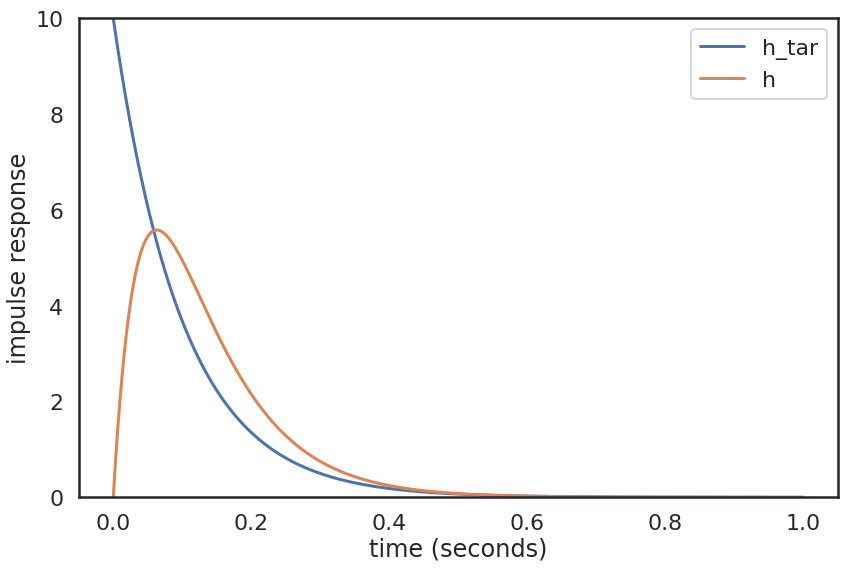

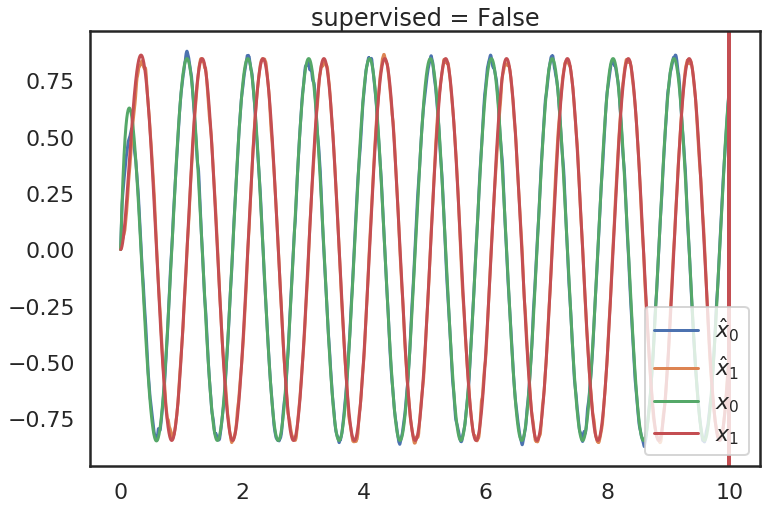

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

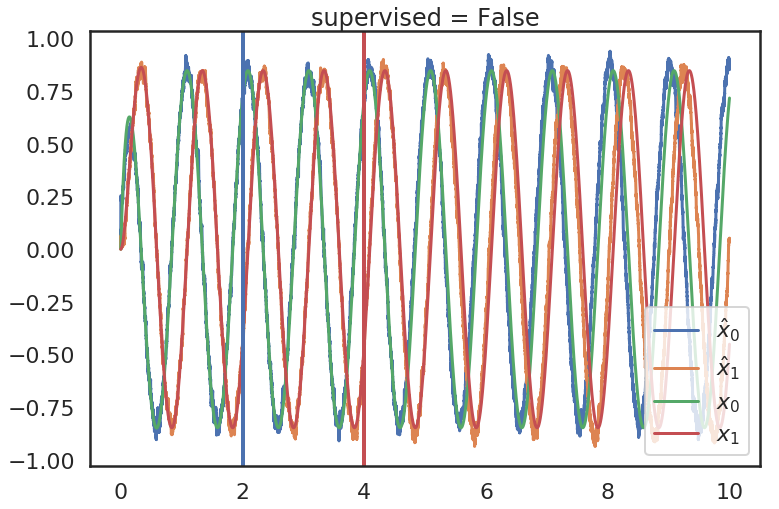

In [200]:
n_neurons = 300
d_init = np.zeros((n_neurons, 2))
h_init = Lowpass(0.1)

nt = WilsonEuler()

d, h = go_oracle(d_init, h_init, t=10, t_supv=10, n_neurons=n_neurons, dt=0.000025,
    neuron_type=nt, max_rates=Uniform(20, 40), tau=0.1, supv=1, order=2, pf=True)

_, _ = go_oracle(d, h, t=10, t_supv=2, t_trans=2, n_neurons=n_neurons, dt=0.000025,
    neuron_type=nt, max_rates=Uniform(20, 40), tau=0.1, supv=0, pf=False)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:198: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

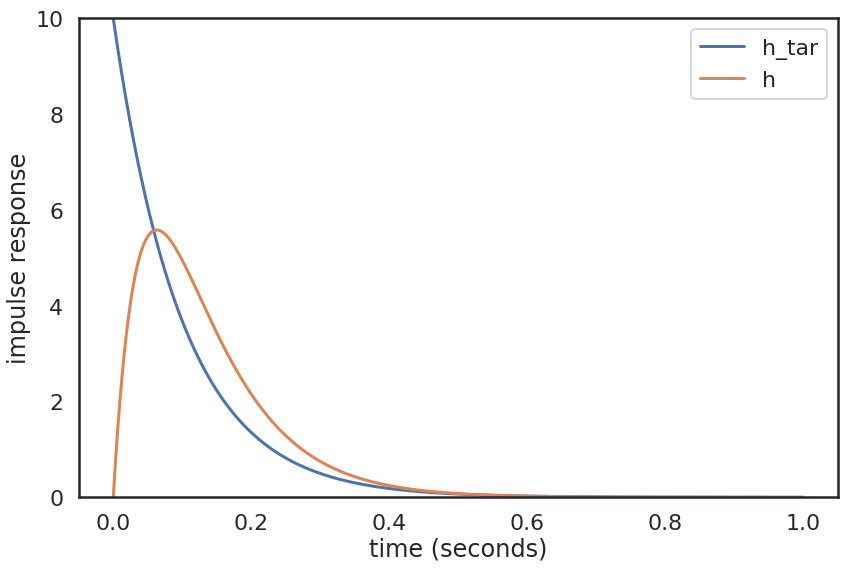

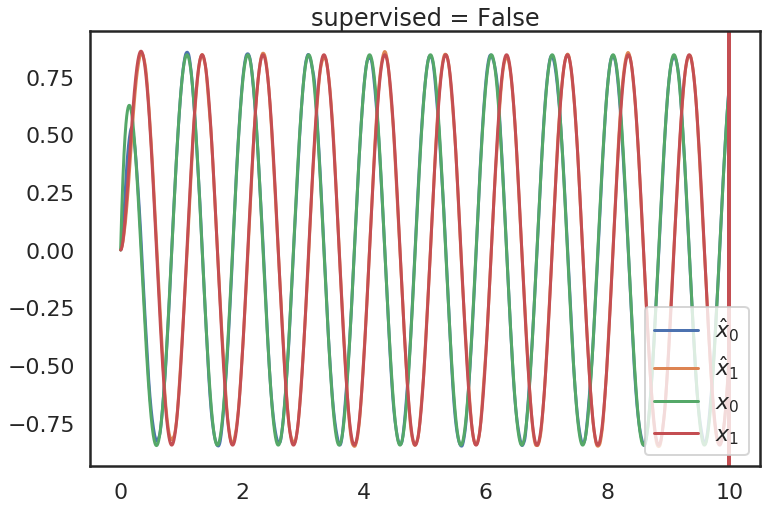

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

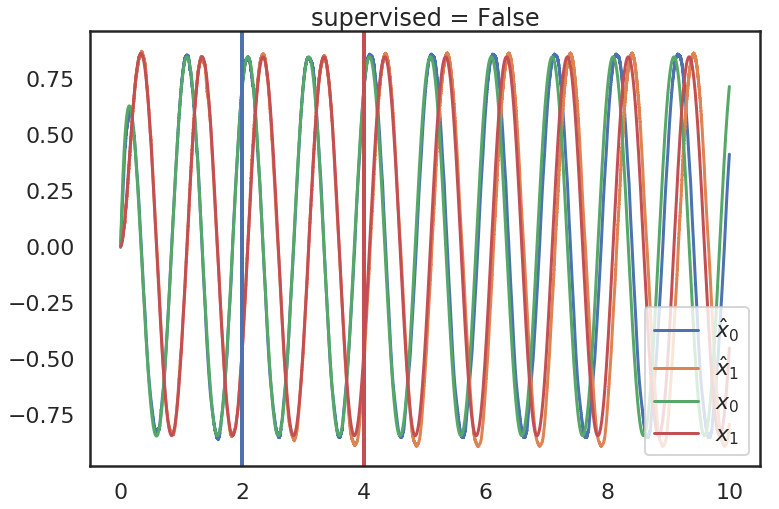

In [19]:
n_neurons = 300
d_init = np.zeros((n_neurons, 2))
h_init = Lowpass(0.1)

nt = WilsonEuler()

d, h = go_oracle(d_init, h_init, t=10, t_supv=10, n_neurons=n_neurons, dt=0.001,
    neuron_type=nt, max_rates=Uniform(20, 40), tau=0.1, supv=1, order=2, pf=True)

_, _ = go_oracle(d, h, t=10, t_supv=2, t_trans=2, n_neurons=n_neurons, dt=0.001,
    neuron_type=nt, max_rates=Uniform(20, 40), tau=0.1, supv=0, pf=False)

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:198: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:198: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:198: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

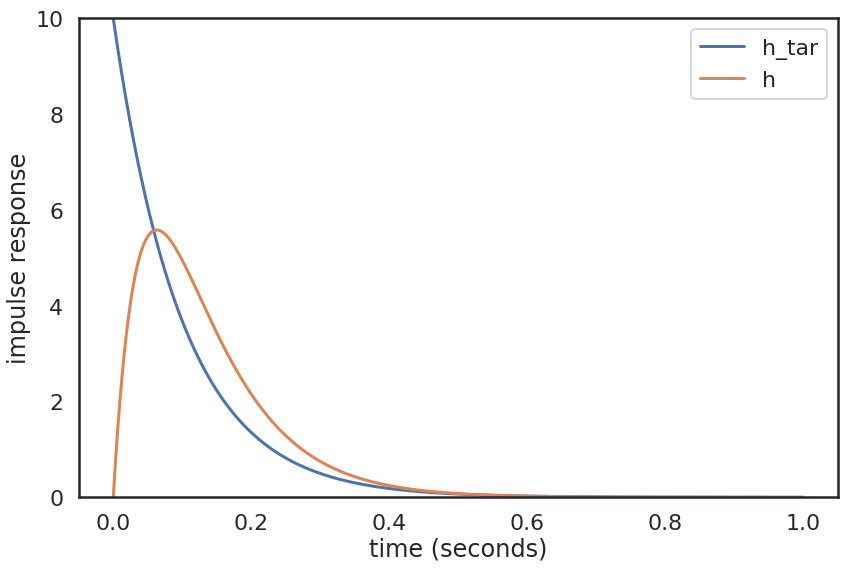

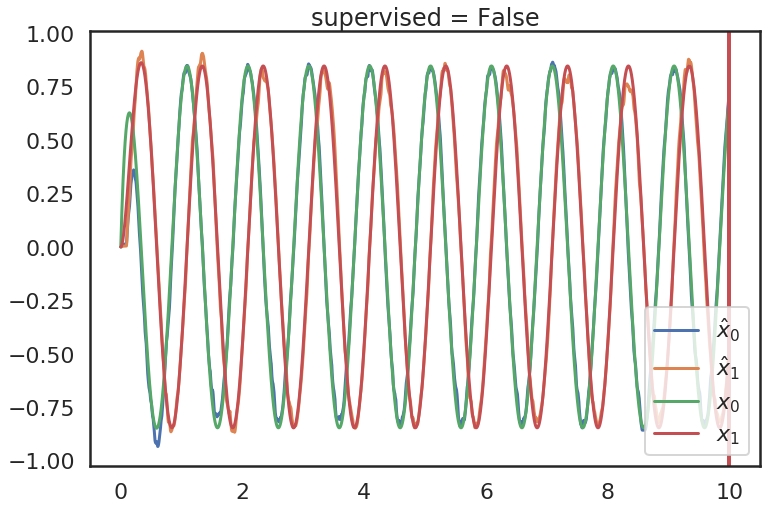

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:198: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:198: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

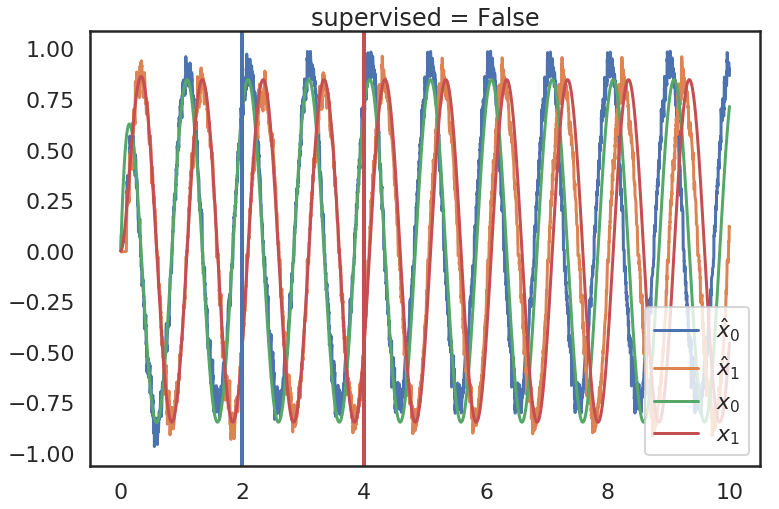

In [8]:
n_neurons = 30
d_init = np.zeros((n_neurons, 2))
h_init = Lowpass(0.1)

nt = DurstewitzNeuron()

d, h = go_oracle(d_init, h_init, t=10, t_supv=10, n_neurons=n_neurons, dt=0.001,
    neuron_type=nt, max_rates=Uniform(20, 40), tau=0.1, supv=1, order=2, pf=True)

_, _ = go_oracle(d, h, t=10, t_supv=2, t_trans=2, n_neurons=n_neurons, dt=0.001,
    neuron_type=nt, max_rates=Uniform(20, 40), tau=0.1, supv=0, pf=False)

In [8]:
n_neurons = 30
d_init = np.zeros((n_neurons, 2))
h_init = Lowpass(0.1)

nt = DurstewitzNeuron()

d, h = go_oracle(d_init, h_init, t=10, t_supv=10, n_neurons=n_neurons, dt=0.001, opt=True, maxiter=1,
    neuron_type=nt, max_rates=Uniform(20, 40), tau=0.1, supv=1, order=2, pf=True)

_, _ = go_oracle(d, h, t=10, t_supv=2, t_trans=2, n_neurons=n_neurons, dt=0.001, opt=False,
    neuron_type=nt, max_rates=Uniform(20, 40), tau=0.1, supv=0, pf=False)

<Connection gbtrain>


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:198: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


iteration 0, remaining neurons 30


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:198: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

ValueError: operands could not be broadcast together with shapes (20,) (2,) 